In [1]:
%cd ../tti-explorer
%pip install -q .

/home/gejinchen/Desktop/l48/project/tti-explorer
Note: you may need to restart the kernel to use updated packages.


In [2]:
### General imports
%matplotlib inline
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import seed
seed(42)

import tti
from tti import simulation

from utils import *

In [3]:
from emukit.test_functions import forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.core import ContinuousParameter, ParameterSpace, DiscreteParameter

# def target_function(X):
#     # X has shape (N, 2)
#     config_details = {0 : {"name": "compliance", "config": "policy_config"}, 
#                       1 : {"name": "go_to_school_prob", "config": "policy_config"}} 
#     r_array = np.array([simulation(x, config_details)['Effective R'] for x in X])[:,None]
#     return r_array

# def constraint(X):
#     # X has shape (N, 2)
#     compliance = X[:,0]
#     go_to_school_prob = X[:,1]
    
#     # Use x**2 means the hgiher the compliance, the harder to increase compliance
#     compliance_cost = compliance**2
#     # Use 1/x means the lower the go_to_school_prob, the harder to decrease go_to_school_prob.(Maybe not true)
#     # Plus 0.001 to avoid division by 0
#     go_to_school_prob_cost = 1 / (go_to_school_prob+0.001)
    
#     # Weighted by coefficients. -1.0 means cost <= 1.0
#     total_cost = compliance_cost + 0.05*go_to_school_prob_cost - 1.0
#     total_cost = total_cost[:,None]
#     return total_cost


def config_cost(X):
    total_cost = np.zeros_like(X[:,0], dtype=float)
    
    testing_delay = X[:,0]
    testing_delay_cost = 5 / testing_delay
    total_cost += 0.4*testing_delay_cost
#     print ("testing_delay_cost: ", testing_delay_cost)
    
    manual_trace_delay = X[:,1]
    manual_trace_delay_cost = 5 / manual_trace_delay
    total_cost += 0.4*manual_trace_delay_cost
#     print ("manual_trace_delay_cost: ", manual_trace_delay_cost)
    
    manual_work_trace_prob = X[:,2]
    manual_work_trace_prob_cost = manual_work_trace_prob**3
    total_cost += 0.4*manual_work_trace_prob_cost
#     print ("manual_work_trace_prob_cost: ", manual_work_trace_prob_cost)
    
    manual_othr_trace_prob = X[:,3]
    manual_othr_trace_prob_cost = manual_othr_trace_prob**3
    total_cost += 0.4*manual_othr_trace_prob_cost
#     print ("manual_othr_trace_prob_cost: ", manual_othr_trace_prob_cost)
    
    app_cov = X[:,4]
    app_cov_cost = app_cov**2
    total_cost += 0.5*app_cov_cost
#     print ("app_cov_cost: ", app_cov_cost)
    
    compliance = X[:,5]
    compliance_cost = compliance**2
    total_cost += 2*compliance_cost
#     print ("compliance_cost: ", compliance_cost)
    
    go_to_school_prob = X[:,6]
    go_to_school_prob_cost = 1 / (go_to_school_prob+0.1)
    total_cost += 0.2*go_to_school_prob_cost
#     print ("go_to_school_prob_cost: ", go_to_school_prob_cost)
    
    wfh_prob = X[:,7]
    wfh_prob_cost = wfh_prob**3
    total_cost += 5*wfh_prob_cost
#     print ("wfh_prob_cost: ", wfh_prob_cost)
    
    return total_cost


def composite_f(X):
    config_details = {0 : {"name": "testing_delay",          "config": "policy_config"}, 
                      1 : {"name": "manual_trace_delay",     "config": "policy_config"}, 
                      2 : {"name": "manual_work_trace_prob", "config": "policy_config"}, 
                      3 : {"name": "manual_othr_trace_prob", "config": "policy_config"}, 
                      4 : {"name": "app_cov",                "config": "policy_config"}, 
                      5 : {"name": "compliance",             "config": "policy_config"}, 
                      6 : {"name": "go_to_school_prob",      "config": "policy_config"}, 
                      7 : {"name": "wfh_prob",               "config": "policy_config"}} 
    
    dict_array = np.array([simulation(x, config_details) for x in X])
#     print (dict_array)
    r_array = np.array([dic['Effective R'] for dic in dict_array])
    man_trace_array = np.array([dic['# Manual Traces'] for dic in dict_array])
    app_trace_array = np.array([dic['# App Traces'] for dic in dict_array])
    tests_array = np.array([dic['# Tests Needed'] for dic in dict_array])
    quarantine_array = np.array([dic['# PersonDays Quarantined'] for dic in dict_array])
    
    cofig_costs = config_cost(X) * 20
    
    # 200 is the constraint, costs_array should be smaller than 0 to meet the constraint
    costs_array = man_trace_array + tests_array + 4*quarantine_array + cofig_costs - 200
    return r_array[:,None], costs_array[:,None]



p0 = DiscreteParameter('x0', [1, 2, 3, 4, 5])
p1 = DiscreteParameter('x1', [1, 2, 3, 4, 5])
p2 = ContinuousParameter('x2', 0, 1)
p3 = ContinuousParameter('x3', 0, 1)
p4 = ContinuousParameter('x4', 0, 1)
p5 = ContinuousParameter('x5', 0, 1)
p6 = ContinuousParameter('x6', 0, 1)
p7 = ContinuousParameter('x7', 0, 1)
space = ParameterSpace([p0, p1, p2, p3, p4, p5, p6, p7])

In [4]:
# print (composite_f(np.array([[1, 1, 1, 1, 1, 1, 0, 1]])))
# config_cost(np.array([[1, 1, 1, 1, 1, 1, 0, 1]]))

In [5]:
from emukit.core.initial_designs import RandomDesign
design = SobolDesign(space)
# Number of initial design points
n_initial_points = 50
# Number of total random sampled points, the extra samples are used to compare with GP results, so
# n_initial_points - n_initial_points must equal number of GP iterations
n_total_points = 150
random_design = design.get_samples(n_total_points)

In [6]:
# # Only for 3D
# res = 50
# dim_0 = np.linspace(space.parameters[0].min, space.parameters[0].max, res)[:, None]
# dim_1 = np.linspace(space.parameters[1].min, space.parameters[1].max, res)[:, None]
# dim_2 = np.linspace(space.parameters[2].min, space.parameters[2].max, res)[:, None]
# dim_0, dim_1, dim_2 = np.meshgrid(dim_0, dim_1, dim_2)
# dim_0 = dim_0.flatten()[:, None]
# dim_1 = dim_1.flatten()[:, None]
# dim_2 = dim_2.flatten()[:, None]
# x_plot_3d = np.concatenate((dim_0, dim_1, dim_2), axis=1)

res = 200
# The 2 dimensions not in dim_slicing will be ploted, dim_slicing includes the fixed value of other dimensions
dim_slicing = {0:3, 1:3, 2:0.95, 3:0.95, 4:0.35, 7:0.1}
dim_to_plot = []
for i in range(space.dimensionality):
    if not i in dim_slicing.keys():
        dim_to_plot.append(i)
assert len(dim_to_plot) == 2
dim_0 = np.linspace(space.parameters[dim_to_plot[0]].min, space.parameters[dim_to_plot[0]].max, res)[:, None]
dim_1 = np.linspace(space.parameters[dim_to_plot[1]].min, space.parameters[dim_to_plot[1]].max, res)[:, None]
dim_0, dim_1 = np.meshgrid(dim_0, dim_1)
dim_0 = dim_0.flatten()[:, None]
dim_1 = dim_1.flatten()[:, None]
x_plot = np.concatenate((dim_0, dim_1), axis=1)
dims = [None]*space.dimensionality
dims[dim_to_plot[0]] = dim_0
dims[dim_to_plot[1]] = dim_1
for key, value in dim_slicing.items():
    dim_fix = np.zeros_like(dim_0)
    dim_fix.fill(value)
    dims[key] = dim_fix
x_plot_eval = np.concatenate(dims, axis=1)

In [7]:
r_array, costs_array = composite_f(random_design)
# Y_init = target_function(random_design)
# Yc_init = constraint(random_design)

# Only take a part of random_design as initial design, the remaining are for comparison
X_init = random_design[:n_initial_points]
Y_init = r_array[:n_initial_points]
Yc_init = costs_array[:n_initial_points]

X_rand = random_design
Y_rand = r_array
Yc_rand = costs_array

In [8]:
import GPy
from GPy.kern import Matern52
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper

f_model = GPy.models.GPRegression(X_init, Y_init, Matern52(X_init.shape[1], variance=1., ARD=False), noise_var=0.01)
f_model = GPyModelWrapper(f_model, n_restarts=10)
f_model.optimize()
con_model = GPy.models.GPRegression(X_init, Yc_init, Matern52(X_init.shape[1], variance=1., ARD=False), noise_var=0.01)
con_model = GPyModelWrapper(con_model, n_restarts=10)
con_model.optimize()

# plot_3d(X_init[:,0].squeeze(), X_init[:,1].squeeze(), X_init[:,2].squeeze())

# mu_plot, var_plot = f_model.predict(x_plot_eval)
# plot_f(X_init[:,dim_to_plot[0]].squeeze(), X_init[:,dim_to_plot[1]].squeeze(), 
#        x_plot, mu_plot.squeeze(), var_plot.squeeze())

Optimization restart 1/10, f = -6.727184355454575
Optimization restart 2/10, f = -6.727184355799238
Optimization restart 3/10, f = -6.7271843555318895
Optimization restart 4/10, f = -6.727184355263663
Optimization restart 5/10, f = -6.727184355558293
Optimization restart 6/10, f = -6.727184354171275
Optimization restart 7/10, f = -6.72718435572077
Optimization restart 8/10, f = -6.727184355689346
Optimization restart 9/10, f = -6.727184356078574
Optimization restart 10/10, f = -6.727184355847381
Optimization restart 1/10, f = 310.08437758159926
Optimization restart 2/10, f = 307.599997189405
Optimization restart 3/10, f = 341.2691436073387
Optimization restart 4/10, f = 303.46695252834724
Optimization restart 5/10, f = 303.07898282897213


 /home/gejinchen/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:565: RuntimeWarning:overflow encountered in square
 /home/gejinchen/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:565: RuntimeWarning:invalid value encountered in multiply


Optimization restart 6/10, f = 253.35654412540035
Optimization restart 7/10, f = 303.4668551927398
Optimization restart 8/10, f = 269.7645496692772
Optimization restart 9/10, f = 303.07897160137463
Optimization restart 10/10, f = 307.49889967489577


In [9]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, ProbabilityOfFeasibility
from emukit.core.acquisition import IntegratedHyperParameterAcquisition

ei_acquisition = MyExpectedImprovement(f_model, con_model)
pof_acquisition = ProbabilityOfFeasibility(con_model)
composite_acquisition = ei_acquisition*pof_acquisition

# ei_plot = ei_acquisition.evaluate(x_plot_eval)
# pof_plot = pof_acquisition.evaluate(x_plot_eval)
# composite_plot = composite_acquisition.evaluate(x_plot_eval)
# plot_acquisition(X_init[:,dim_to_plot[0]].squeeze(), X_init[:,dim_to_plot[1]].squeeze(), 
#                  x_plot, ei_plot.squeeze(), pof_plot.squeeze(), composite_plot.squeeze())

# pof_plot_3d = pof_acquisition.evaluate(x_plot_3d)
# plot_pof_3d(X_init[:,0].squeeze(), X_init[:,1].squeeze(), X_init[:,2].squeeze(), x_plot_3d, pof_plot_3d.squeeze())

In [10]:
from emukit.core.optimization import GradientAcquisitionOptimizer
optimizer = GradientAcquisitionOptimizer(space)
X = X_init
Y = Y_init
Yc = Yc_init
iterations = n_total_points - n_initial_points
for i in range(iterations):
    ei_acquisition.update_parameters()
    pof_acquisition.update_parameters()
    composite_acquisition = ei_acquisition*pof_acquisition
    x_new, _ = optimizer.optimize(composite_acquisition)
    X = np.append(X, x_new, axis=0)
    
    # May be a very small neg number
    x_new = np.clip(x_new, 0, 10)
    y_new, yc_new = composite_f(x_new)
    
#     y_new = target_function(x_new)
    Y = np.append(Y, y_new, axis=0)
    f_model.set_data(X, Y)
    f_model.optimize()
    
#     yc_new = constraint(x_new)
    Yc = np.append(Yc, yc_new, axis=0)
    con_model.set_data(X, Yc)
    con_model.optimize()


Optimization restart 1/10, f = -7.677897510208346
Optimization restart 2/10, f = -7.678182565544937
Optimization restart 3/10, f = -7.678182565447042


 /home/gejinchen/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 4/10, f = -7.6781825646570745
Optimization restart 5/10, f = -7.678182565270472
Optimization restart 6/10, f = -7.6781825650961615
Optimization restart 7/10, f = -7.678182565334467
Optimization restart 8/10, f = -7.678182562490562
Optimization restart 9/10, f = -7.678182565270909
Optimization restart 10/10, f = -7.67818256544923
Optimization restart 1/10, f = 260.9247996838891
Optimization restart 2/10, f = 312.4316990880075
Optimization restart 3/10, f = 309.1640679060735
Optimization restart 4/10, f = 309.16410129976606
Optimization restart 5/10, f = 274.73378793247775
Optimization restart 6/10, f = 309.1640927804473
Optimization restart 7/10, f = 260.9198753826365
Optimization restart 8/10, f = 346.3915805919628
Optimization restart 9/10, f = 309.3205737762702


 /home/gejinchen/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:565: RuntimeWarning:overflow encountered in multiply


Optimization restart 10/10, f = 309.48193987588485



Optimization restart 1/10, f = -8.799667149567021
Optimization restart 2/10, f = -8.802156990897423
Optimization restart 3/10, f = -8.802156991238668
Optimization restart 4/10, f = -8.80215699131631
Optimization restart 5/10, f = -8.802156991469957
Optimization restart 6/10, f = -8.802156989831609
Optimization restart 7/10, f = -8.802156991405159
Optimization restart 8/10, f = -8.80215699128907
Optimization restart 9/10, f = -8.80215699126926
Optimization restart 10/10, f = -8.802156991037837
Optimization restart 1/10, f = 267.02918802376547
Optimization restart 2/10, f = 267.02864452215874
Optimization restart 3/10, f = 317.0689125480708
Optimization restart 4/10, f = 314.26997762886083
Optimization restart 5/10, f = 267.02864452808154
Optimization restart 6/10, f = 314.8039570757314
Optimization restart 7/10, f = 314.8041579083777
Optimization restart 8/10, f = 341.91557355563646
Optimization restart 9/10, f = 267.0286447548813
Optimization restart 10/10, f = 314.8040141350936



Optimization restart 1/10, f = -9.561141084541816
Optimization restart 2/10, f = -9.56241703859973
Optimization restart 3/10, f = -9.562417040025025
Optimization restart 4/10, f = -9.562416075795916
Optimization restart 5/10, f = -9.562417039874784
Optimization restart 6/10, f = -9.562417039771297
Optimization restart 7/10, f = -9.562417039090224
Optimization restart 8/10, f = -9.56241704018857
Optimization restart 9/10, f = -9.562417039950503
Optimization restart 10/10, f = -9.562417038508155
Optimization restart 1/10, f = 272.8196485425408
Optimization restart 2/10, f = 323.90739558148294
Optimization restart 3/10, f = 347.8957450626235
Optimization restart 4/10, f = 320.4330077051226
Optimization restart 5/10, f = 320.43309547705843
Optimization restart 6/10, f = 320.43300759655284
Optimization restart 7/10, f = 320.4330140561807
Optimization restart 8/10, f = 343.7289351696785
Optimization restart 9/10, f = 352.9516239267105
Optimization restart 10/10, f = 313.15286392116826


 /home/gejinchen/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide



Optimization restart 1/10, f = -10.759783263541095
Optimization restart 2/10, f = -10.761136257621551
Optimization restart 3/10, f = -10.761136257671431
Optimization restart 4/10, f = -10.761136257806335
Optimization restart 5/10, f = -10.76113625772549
Optimization restart 6/10, f = -10.761136257055593
Optimization restart 7/10, f = -10.76113625783126
Optimization restart 8/10, f = -10.761136257546848
Optimization restart 9/10, f = -10.761136257992707
Optimization restart 10/10, f = -10.76113625725133
Optimization restart 1/10, f = 278.1028537771848
Optimization restart 2/10, f = 326.0307491128883
Optimization restart 3/10, f = 285.1871326779854
Optimization restart 4/10, f = 285.1871326779685
Optimization restart 5/10, f = 285.1871326783669
Optimization restart 6/10, f = 331.9974218649787
Optimization restart 7/10, f = 329.50910706268127
Optimization restart 8/10, f = 328.37261993888285
Optimization restart 9/10, f = 335.758510533124
Optimization restart 10/10, f = 285.1871326788965


Optimization restart 1/10, f = -11.68449380485891
Optimization restart 2/10, f = -11.691781890869823
Optimization restart 3/10, f = -11.691781891217445
Optimization restart 4/10, f = -11.69178189067297
Optimization restart 5/10, f = -11.691781890637898
Optimization restart 6/10, f = -11.691781891166585
Optimization restart 7/10, f = -11.691781890846496
Optimization restart 8/10, f = -11.691781890833767
Optimization restart 9/10, f = -11.69178189080812
Optimization restart 10/10, f = -11.691781891283767
Optimization restart 1/10, f = 283.9119342326034
Optimization restart 2/10, f = 366.14269537844433
Optimization restart 3/10, f = 331.6772742574069
Optimization restart 4/10, f = 331.67726559031655
Optimization restart 5/10, f = 330.92407334659765
Optimization restart 6/10, f = 283.9044044660957
Optimization restart 7/10, f = 283.90440438761067
Optimization restart 8/10, f = 283.90440440029806
Optimization restart 9/10, f = 368.5726778292344
Optimization restart 10/10, f = 340.105533529


Optimization restart 1/10, f = -12.546893783105904
Optimization restart 2/10, f = -12.549679312553302
Optimization restart 3/10, f = -12.54967931221293
Optimization restart 4/10, f = -12.549679312100494
Optimization restart 5/10, f = -12.549679249022773
Optimization restart 6/10, f = -12.549679312853222
Optimization restart 7/10, f = -12.549679312538679
Optimization restart 8/10, f = -12.549679312497254
Optimization restart 9/10, f = -12.549679312178412
Optimization restart 10/10, f = -12.549679312439363
Optimization restart 1/10, f = 289.70223320694936
Optimization restart 2/10, f = 354.72957677588283
Optimization restart 3/10, f = 369.0554621967784
Optimization restart 4/10, f = 337.33032283223525
Optimization restart 5/10, f = 294.8016569415045
Optimization restart 6/10, f = 337.33023633962597
Optimization restart 7/10, f = 289.66929669316204
Optimization restart 8/10, f = 337.33021098778704
Optimization restart 9/10, f = 337.3302105314769
Optimization restart 10/10, f = 337.330210


Optimization restart 1/10, f = -13.15493607060856
Optimization restart 2/10, f = -13.1556144905691
Optimization restart 3/10, f = -13.155614490913017
Optimization restart 4/10, f = -13.15561449099524
Optimization restart 5/10, f = -13.155614491042687
Optimization restart 6/10, f = -13.155614491227748
Optimization restart 7/10, f = -13.155614491152306
Optimization restart 8/10, f = -13.155614490797955
Optimization restart 9/10, f = -13.155614490730407
Optimization restart 10/10, f = -13.155614491106025
Optimization restart 1/10, f = 294.4613427868911
Optimization restart 2/10, f = 341.98265404099624
Optimization restart 3/10, f = 342.89855018482405
Optimization restart 4/10, f = 379.63229574582436
Optimization restart 5/10, f = 342.8985104395967
Optimization restart 6/10, f = 351.7274838828809
Optimization restart 7/10, f = 349.5329004162842
Optimization restart 8/10, f = 565.3246427388359
Optimization restart 9/10, f = 342.8985075323964
Optimization restart 10/10, f = 294.460613580088


Optimization restart 1/10, f = -14.296172484266158
Optimization restart 2/10, f = -14.29617248502317
Optimization restart 3/10, f = -14.296172485233047
Optimization restart 4/10, f = -14.296172484934697
Optimization restart 5/10, f = -14.296172484867746
Optimization restart 6/10, f = -14.29617248455165
Optimization restart 7/10, f = -14.296172484940175
Optimization restart 8/10, f = -14.296172485052857
Optimization restart 9/10, f = -14.296172485286444
Optimization restart 10/10, f = -14.29617248428897
Optimization restart 1/10, f = 299.10930156195434
Optimization restart 2/10, f = 360.9925091048865
Optimization restart 3/10, f = 299.1789418505879
Optimization restart 4/10, f = 348.4469962212779
Optimization restart 5/10, f = 348.44695143897945
Optimization restart 6/10, f = 348.44694841698504
Optimization restart 7/10, f = 299.1789418530946
Optimization restart 8/10, f = 348.4469552656078
Optimization restart 9/10, f = 299.1789418507671
Optimization restart 10/10, f = 348.44694744500


Optimization restart 1/10, f = -15.459397860032535
Optimization restart 2/10, f = -15.483092866341558
Optimization restart 3/10, f = -15.483092866669914
Optimization restart 4/10, f = -15.483092866691397
Optimization restart 5/10, f = -15.483092866412871
Optimization restart 6/10, f = -15.483092866688445
Optimization restart 7/10, f = -15.48309285341459
Optimization restart 8/10, f = -15.483092864231828
Optimization restart 9/10, f = -15.483092866600447
Optimization restart 10/10, f = -15.483092866620876
Optimization restart 1/10, f = 303.686489249756
Optimization restart 2/10, f = 301.3603961088482
Optimization restart 3/10, f = 353.98345149616597
Optimization restart 4/10, f = 301.3603960728993
Optimization restart 5/10, f = 301.3603960733796
Optimization restart 6/10, f = 301.36039607433355
Optimization restart 7/10, f = 353.98344499315357
Optimization restart 8/10, f = 353.98357219981284
Optimization restart 9/10, f = 353.98350481818636
Optimization restart 10/10, f = 413.23817684


Optimization restart 1/10, f = -16.202550774787362
Optimization restart 2/10, f = -16.203939748958295
Optimization restart 3/10, f = -16.203939743909064
Optimization restart 4/10, f = -16.203939749038685
Optimization restart 5/10, f = -16.20393974892319
Optimization restart 6/10, f = -16.20393935797003
Optimization restart 7/10, f = -16.203939744241207
Optimization restart 8/10, f = -16.203939748938467
Optimization restart 9/10, f = -16.203939749020098
Optimization restart 10/10, f = -16.20393974298816
Optimization restart 1/10, f = 308.0813575095593
Optimization restart 2/10, f = 359.9139385994304
Optimization restart 3/10, f = 308.0714744513982
Optimization restart 4/10, f = 374.1655332464704
Optimization restart 5/10, f = 362.15090099829166
Optimization restart 6/10, f = 388.5589255313441
Optimization restart 7/10, f = 358.693286571868
Optimization restart 8/10, f = 409.45253855681125
Optimization restart 9/10, f = 365.9715049052928
Optimization restart 10/10, f = 360.4718597419263


Optimization restart 1/10, f = -17.201224534025496
Optimization restart 2/10, f = -17.20905055526189
Optimization restart 3/10, f = -17.209049537922187
Optimization restart 4/10, f = -17.209050555113624
Optimization restart 5/10, f = -17.209050554936766
Optimization restart 6/10, f = -17.209050553545353
Optimization restart 7/10, f = -17.209050554851554
Optimization restart 8/10, f = -17.209050497185483
Optimization restart 9/10, f = -17.209050549864806
Optimization restart 10/10, f = -17.2090505551629
Optimization restart 1/10, f = 313.32881561224633
Optimization restart 2/10, f = 380.40859117270367
Optimization restart 3/10, f = 343.15573997357944
Optimization restart 4/10, f = 313.3263575350059
Optimization restart 5/10, f = 365.69524132610377
Optimization restart 6/10, f = 365.69521905519554
Optimization restart 7/10, f = 320.33719374895185
Optimization restart 8/10, f = 367.5984685684847
Optimization restart 9/10, f = 365.6952510756163
Optimization restart 10/10, f = 365.69521728


Optimization restart 1/10, f = -18.38926728004606
Optimization restart 2/10, f = -18.367156239966103
Optimization restart 3/10, f = -18.38972172505102
Optimization restart 4/10, f = -18.38972172574818
Optimization restart 5/10, f = -18.389721725781715
Optimization restart 6/10, f = -18.38972172524822
Optimization restart 7/10, f = -18.38972170214742
Optimization restart 8/10, f = -18.38972169862775
Optimization restart 9/10, f = -18.38972172520307
Optimization restart 10/10, f = -18.38972172560726
Optimization restart 1/10, f = 319.5758574478019
Optimization restart 2/10, f = 383.3710363594202
Optimization restart 3/10, f = 396.8692401696338
Optimization restart 4/10, f = 371.32187084979256
Optimization restart 5/10, f = 427.9300276535028
Optimization restart 6/10, f = 371.32183456969676
Optimization restart 7/10, f = 319.5594938506598
Optimization restart 8/10, f = 326.5345520955566
Optimization restart 9/10, f = 409.6303032843542
Optimization restart 10/10, f = 359.77166875092274



Optimization restart 1/10, f = -19.34691045001343
Optimization restart 2/10, f = -19.346910449514894
Optimization restart 3/10, f = -19.346910449487805
Optimization restart 4/10, f = -19.346910449329684
Optimization restart 5/10, f = -19.346910446815873
Optimization restart 6/10, f = -19.346910449031707
Optimization restart 7/10, f = -19.346910446124376
Optimization restart 8/10, f = -19.346910449668087
Optimization restart 9/10, f = -19.346910450089524
Optimization restart 10/10, f = -19.34691045041936
Optimization restart 1/10, f = 325.03912919485293
Optimization restart 2/10, f = 325.03911621499407
Optimization restart 3/10, f = 325.03911621502345
Optimization restart 4/10, f = 325.0391164561354
Optimization restart 5/10, f = 325.0391162152713
Optimization restart 6/10, f = 389.5089720053771
Optimization restart 7/10, f = 321.67385854706885
Optimization restart 8/10, f = 377.1691636384606
Optimization restart 9/10, f = 324.4713513746927
Optimization restart 10/10, f = 386.429593961


Optimization restart 1/10, f = -20.60823989054022
Optimization restart 2/10, f = -20.608541850002045
Optimization restart 3/10, f = -20.608541851421293
Optimization restart 4/10, f = -20.608541851801117
Optimization restart 5/10, f = -20.505689338537806
Optimization restart 6/10, f = -20.60854185157268
Optimization restart 7/10, f = -20.568816867107643
Optimization restart 8/10, f = -20.608541807521433
Optimization restart 9/10, f = -20.608541852541308
Optimization restart 10/10, f = -20.60854184773335
Optimization restart 1/10, f = 327.1382456248721
Optimization restart 2/10, f = 382.7491514817191
Optimization restart 3/10, f = 388.4362627678289
Optimization restart 4/10, f = 402.29416244493825
Optimization restart 5/10, f = 382.7492416792321
Optimization restart 6/10, f = 330.4648730895623
Optimization restart 7/10, f = 386.4931340931904
Optimization restart 8/10, f = 382.7491658730214
Optimization restart 9/10, f = 330.4648730902213
Optimization restart 10/10, f = 382.749185518377



Optimization restart 1/10, f = -21.841382246139723
Optimization restart 2/10, f = -21.844188278505683
Optimization restart 3/10, f = -21.844188279444474
Optimization restart 4/10, f = -21.84418827900499
Optimization restart 5/10, f = -21.775155622091525
Optimization restart 6/10, f = -21.844188279349048
Optimization restart 7/10, f = -21.84418827857224
Optimization restart 8/10, f = -21.844188278328353
Optimization restart 9/10, f = -21.844188278584248
Optimization restart 10/10, f = -21.84418826916798
Optimization restart 1/10, f = 331.515585099502
Optimization restart 2/10, f = 386.3538904547356
Optimization restart 3/10, f = 390.43161152443383
Optimization restart 4/10, f = 409.39859018397783
Optimization restart 5/10, f = 377.17340570896175
Optimization restart 6/10, f = 388.2534688038006
Optimization restart 7/10, f = 333.6465728976346
Optimization restart 8/10, f = 388.2533797342238
Optimization restart 9/10, f = 333.64657297577537
Optimization restart 10/10, f = 331.10931151529


Optimization restart 1/10, f = -22.992202978295822
Optimization restart 2/10, f = -23.022346898663542
Optimization restart 3/10, f = -23.02234689070938
Optimization restart 4/10, f = -23.02234689639291
Optimization restart 5/10, f = -23.022346898785578
Optimization restart 6/10, f = -23.02234689558304
Optimization restart 7/10, f = -23.022346898493375
Optimization restart 8/10, f = -23.02234689867924
Optimization restart 9/10, f = -23.022346898801928
Optimization restart 10/10, f = -23.02234689174542
Optimization restart 1/10, f = 335.4308944394107
Optimization restart 2/10, f = 343.3128376743694
Optimization restart 3/10, f = 417.27513946722405
Optimization restart 4/10, f = 334.8092686812998
Optimization restart 5/10, f = 397.99420058107404
Warning - optimization restart 6/10 failed
Optimization restart 7/10, f = 335.43089392623966


 /home/gejinchen/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:568: RuntimeWarning:overflow encountered in multiply
 /home/gejinchen/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:568: RuntimeWarning:invalid value encountered in multiply


Optimization restart 8/10, f = 334.80926862489304
Optimization restart 9/10, f = 334.80926863846975
Optimization restart 10/10, f = 335.4308935880531



Optimization restart 1/10, f = -24.208360479574296
Optimization restart 2/10, f = -24.23546267869937
Optimization restart 3/10, f = -24.23546267948312
Optimization restart 4/10, f = -24.235462679498696
Optimization restart 5/10, f = -24.2354626789341
Optimization restart 6/10, f = -24.23546267903039
Optimization restart 7/10, f = -24.235462679032295
Optimization restart 8/10, f = -24.235462679391127
Optimization restart 9/10, f = -24.23546267629083
Optimization restart 10/10, f = -24.23546267880453
Optimization restart 1/10, f = 339.36974914835304
Optimization restart 2/10, f = 399.75455423801645
Optimization restart 3/10, f = 339.3633734402109
Optimization restart 4/10, f = 436.1298325213601
Optimization restart 5/10, f = 409.0886594519466
Optimization restart 6/10, f = 420.9587434731602
Optimization restart 7/10, f = 425.19551610410724
Optimization restart 8/10, f = 399.21540832621156
Optimization restart 9/10, f = 339.36337343801836
Optimization restart 10/10, f = 512.3939013352447


Optimization restart 1/10, f = -25.385865936793238
Optimization restart 2/10, f = -25.385865936895065
Optimization restart 3/10, f = -25.3858659366716
Optimization restart 4/10, f = -25.385865936838222
Optimization restart 5/10, f = -25.385865443354056
Optimization restart 6/10, f = -25.38586593681474
Optimization restart 7/10, f = -25.38586593661531
Optimization restart 8/10, f = -25.385865936567114
Optimization restart 9/10, f = -25.385865875088008
Optimization restart 10/10, f = -25.3858659366759
Optimization restart 1/10, f = 344.51271144582665
Optimization restart 2/10, f = 344.51269414127233
Optimization restart 3/10, f = 406.20766850010756
Optimization restart 4/10, f = 346.14166975119514
Optimization restart 5/10, f = 448.17632974236324
Optimization restart 6/10, f = 428.6342172534863
Optimization restart 7/10, f = 344.51269414111084
Optimization restart 8/10, f = 448.53032343793757
Optimization restart 9/10, f = 446.91797325301536
Optimization restart 10/10, f = 440.020673441


Optimization restart 1/10, f = -26.527829079216595
Optimization restart 2/10, f = -26.527827252854934
Optimization restart 3/10, f = -26.527829055229226
Optimization restart 4/10, f = -26.527829078565098
Optimization restart 5/10, f = -26.527829079295927
Optimization restart 6/10, f = -26.527828966658987
Optimization restart 7/10, f = -26.52782881588349
Optimization restart 8/10, f = -26.527829078012886
Optimization restart 9/10, f = -26.527829079450484
Optimization restart 10/10, f = -26.527829078045514
Optimization restart 1/10, f = 349.371064187824
Optimization restart 2/10, f = 349.36323253843443
Optimization restart 3/10, f = 349.36323254058516
Optimization restart 4/10, f = 410.28662753478005
Optimization restart 5/10, f = 408.37477588072096
Optimization restart 6/10, f = 359.93048530838826
Optimization restart 7/10, f = 410.2866431823307
Optimization restart 8/10, f = 554.7484211743033
Optimization restart 9/10, f = 410.28665621565466
Optimization restart 10/10, f = 411.8230610


Optimization restart 1/10, f = -27.61750356355185
Optimization restart 2/10, f = -27.617503563610498
Optimization restart 3/10, f = -27.61750356333608
Optimization restart 4/10, f = -27.617503563603734
Optimization restart 5/10, f = -27.61750356246725
Optimization restart 6/10, f = -27.617503562778282
Optimization restart 7/10, f = -27.617503560896658
Optimization restart 8/10, f = -27.617503562302318
Optimization restart 9/10, f = -27.617503560159662
Optimization restart 10/10, f = -27.617503563626478
Optimization restart 1/10, f = 354.9148527137017
Optimization restart 2/10, f = 418.9922753505173
Optimization restart 3/10, f = 470.46235917630963
Optimization restart 4/10, f = 354.8803625522108
Optimization restart 5/10, f = 414.5115888739806
Optimization restart 6/10, f = 432.5160862377382
Optimization restart 7/10, f = 463.46970876168996
Optimization restart 8/10, f = 568.8227760545038
Optimization restart 9/10, f = 449.66041284274985
Optimization restart 10/10, f = 416.30290101033


Optimization restart 1/10, f = -28.900949349335484
Optimization restart 2/10, f = -28.903404912160752
Optimization restart 3/10, f = -28.903404910758276
Optimization restart 4/10, f = -28.90340488182943
Optimization restart 5/10, f = -28.903404911521896
Optimization restart 6/10, f = -28.9034049113167
Optimization restart 7/10, f = -28.903404912017628
Optimization restart 8/10, f = -28.90340491011689
Optimization restart 9/10, f = -28.90340472937642
Optimization restart 10/10, f = -28.903404911677434
Optimization restart 1/10, f = 359.1397064448627
Optimization restart 2/10, f = 419.20825529780694
Optimization restart 3/10, f = 422.05522343243
Optimization restart 4/10, f = 457.23319421194526
Optimization restart 5/10, f = 358.20863355917356
Optimization restart 6/10, f = 419.4193612426293
Optimization restart 7/10, f = 359.1252819600286
Optimization restart 8/10, f = 428.90117052828447
Optimization restart 9/10, f = 360.26332906937233
Optimization restart 10/10, f = 421.7764117287684


Optimization restart 1/10, f = -30.27911755673378
Optimization restart 2/10, f = -30.27911755927201
Optimization restart 3/10, f = -30.279117559127684
Optimization restart 4/10, f = -30.27911755903847
Optimization restart 5/10, f = -30.27911755730159
Optimization restart 6/10, f = -30.279117558974356
Optimization restart 7/10, f = -30.279117559176072
Optimization restart 8/10, f = -30.27911755902192
Optimization restart 9/10, f = -30.27911674458273
Optimization restart 10/10, f = -30.279117559132885
Optimization restart 1/10, f = 362.5627446852527
Optimization restart 2/10, f = 365.7592485754387
Optimization restart 3/10, f = 466.90455321357257
Optimization restart 4/10, f = 442.24300810035453
Optimization restart 5/10, f = 459.9520129741899
Optimization restart 6/10, f = 360.2081560159534
Optimization restart 7/10, f = 360.20815600925766
Optimization restart 8/10, f = 624.2360485051275
Optimization restart 9/10, f = 365.94473780172086
Optimization restart 10/10, f = 362.5627110397007


Optimization restart 1/10, f = -31.32314569481062
Optimization restart 2/10, f = -31.323145672332856
Optimization restart 3/10, f = -31.323145695125085
Optimization restart 4/10, f = -31.323145694814322
Optimization restart 5/10, f = -31.323145694907495
Optimization restart 6/10, f = -31.32314569373733
Optimization restart 7/10, f = -31.32314569452175
Optimization restart 8/10, f = -31.323145694768755
Optimization restart 9/10, f = -31.323145695081195
Optimization restart 10/10, f = -31.323145695130158
Optimization restart 1/10, f = 364.8437946405639
Optimization restart 2/10, f = 432.75124854911274
Optimization restart 3/10, f = 432.969065380427
Optimization restart 4/10, f = 432.75124856081965
Optimization restart 5/10, f = 527.3128572441057
Optimization restart 6/10, f = 432.7512513763771
Optimization restart 7/10, f = 364.8373909138145
Optimization restart 8/10, f = 432.7512619650374
Optimization restart 9/10, f = 436.3229511896481
Optimization restart 10/10, f = 433.8292507347656


Optimization restart 1/10, f = -32.77874352500804
Optimization restart 2/10, f = -32.78056076725293
Optimization restart 3/10, f = -32.780560767185214
Optimization restart 4/10, f = -32.78056076716422
Optimization restart 5/10, f = -32.78056076722667
Optimization restart 6/10, f = -32.7805607669585
Optimization restart 7/10, f = -32.78056076713696
Optimization restart 8/10, f = -32.78056076695363
Optimization restart 9/10, f = -32.78056076640026
Optimization restart 10/10, f = -32.78056074860757
Optimization restart 1/10, f = 368.8488194681533
Optimization restart 2/10, f = 662.9056704678624
Optimization restart 3/10, f = 438.18548118272395
Optimization restart 4/10, f = 478.4680469355212
Optimization restart 5/10, f = 486.40429539367835
Optimization restart 6/10, f = 461.0993643583473
Optimization restart 7/10, f = 486.301376575449
Optimization restart 8/10, f = 370.97663965796835
Optimization restart 9/10, f = 368.8455131773117
Optimization restart 10/10, f = 542.1374552248448



Optimization restart 1/10, f = -34.10424362454661
Optimization restart 2/10, f = -34.10440999776961
Optimization restart 3/10, f = -34.104409988904145
Optimization restart 4/10, f = -34.104409997914885
Optimization restart 5/10, f = -34.10440998924223
Optimization restart 6/10, f = -34.104409997657946
Optimization restart 7/10, f = -34.104409997876026
Optimization restart 8/10, f = -34.10440999805087
Optimization restart 9/10, f = -34.104409983405425
Optimization restart 10/10, f = -34.104409988934606
Optimization restart 1/10, f = 372.6357237870745
Optimization restart 2/10, f = 443.60792811934255
Optimization restart 3/10, f = 372.6356820613963
Optimization restart 4/10, f = 372.63568206299556
Optimization restart 5/10, f = 439.3353766951538
Optimization restart 6/10, f = 495.3543576914808
Optimization restart 7/10, f = 377.7758948514868
Optimization restart 8/10, f = 381.07854292470245
Optimization restart 9/10, f = 440.7828498155716
Optimization restart 10/10, f = 450.046292057671


Optimization restart 1/10, f = -35.29762341025491
Optimization restart 2/10, f = -35.297623409056996
Optimization restart 3/10, f = -35.29762337416134
Optimization restart 4/10, f = -35.29762340999726
Optimization restart 5/10, f = -35.297623409291795
Optimization restart 6/10, f = -35.29762341037562
Optimization restart 7/10, f = -35.297623409229494
Optimization restart 8/10, f = -35.297623409782155
Optimization restart 9/10, f = -35.297623410229576
Optimization restart 10/10, f = -35.29762341038476
Optimization restart 1/10, f = 380.35602927052867
Optimization restart 2/10, f = 481.3224549358748
Optimization restart 3/10, f = 454.11451188743814
Optimization restart 4/10, f = 449.0767309370297
Optimization restart 5/10, f = 449.03585286438323
Optimization restart 6/10, f = 449.0358491915703
Optimization restart 7/10, f = 379.3662686908918
Optimization restart 8/10, f = 452.83327760813705
Optimization restart 9/10, f = 489.4685115977902
Optimization restart 10/10, f = 446.155261365314


Optimization restart 1/10, f = -36.61897069878697
Optimization restart 2/10, f = -36.62394804774877
Optimization restart 3/10, f = -36.623948047750844
Optimization restart 4/10, f = -36.62394804763017
Optimization restart 5/10, f = -36.623948047910126
Optimization restart 6/10, f = -36.62394804719028
Optimization restart 7/10, f = -36.62394804636686
Optimization restart 8/10, f = -36.623948047664435
Optimization restart 9/10, f = -36.623948047853034
Optimization restart 10/10, f = -36.62394804786753
Optimization restart 1/10, f = 384.0664080168884
Optimization restart 2/10, f = 454.4775803201103
Optimization restart 3/10, f = 454.47757886477666
Optimization restart 4/10, f = 464.43167633354915
Optimization restart 5/10, f = 473.720046905348
Optimization restart 6/10, f = 541.0172109883813
Optimization restart 7/10, f = 455.1044858310375
Optimization restart 8/10, f = 382.35738863350247
Optimization restart 9/10, f = 454.4776092512117
Optimization restart 10/10, f = 384.42696938910956



Optimization restart 1/10, f = -37.753244029458656
Optimization restart 2/10, f = -37.753244024415324
Optimization restart 3/10, f = -37.75324399641698
Optimization restart 4/10, f = -37.75324402963682
Optimization restart 5/10, f = -37.7532440293277
Optimization restart 6/10, f = -37.75324402954154
Optimization restart 7/10, f = -37.75324402927559
Optimization restart 8/10, f = -37.753244029448375
Optimization restart 9/10, f = -37.75324402955296
Optimization restart 10/10, f = -37.75324402982449
Optimization restart 1/10, f = 386.39940234156035
Optimization restart 2/10, f = 459.8970904944921
Optimization restart 3/10, f = 386.3973785331858
Optimization restart 4/10, f = 459.8971356798156
Optimization restart 5/10, f = 490.067373202362
Optimization restart 6/10, f = 456.8713963425679
Optimization restart 7/10, f = 556.5431878832529
Optimization restart 8/10, f = 460.87354240174136
Optimization restart 9/10, f = 386.39737853441994
Optimization restart 10/10, f = 456.87136321238285



Optimization restart 1/10, f = -38.657889463410456
Optimization restart 2/10, f = -38.66150462595357
Optimization restart 3/10, f = -38.66150462344503
Optimization restart 4/10, f = -38.661504625797015
Optimization restart 5/10, f = -38.66150462599132
Optimization restart 6/10, f = -38.66150462646846
Optimization restart 7/10, f = -38.6615046266125
Optimization restart 8/10, f = -38.66150462641095
Optimization restart 9/10, f = -38.661504626159186
Optimization restart 10/10, f = -38.661504557126115
Optimization restart 1/10, f = 388.5609584865807
Optimization restart 2/10, f = 388.54455366491413
Optimization restart 3/10, f = 388.5445536749834
Optimization restart 4/10, f = 465.2911591084555
Optimization restart 5/10, f = 392.46519274879796
Optimization restart 6/10, f = 465.29119236097586
Optimization restart 7/10, f = 388.5445536649532
Optimization restart 8/10, f = 397.2159200246048
Optimization restart 9/10, f = 388.5445536656565
Optimization restart 10/10, f = 467.815243106219



Optimization restart 1/10, f = -39.93265402341166
Optimization restart 2/10, f = -39.932769554753634
Optimization restart 3/10, f = -39.93276960007445
Optimization restart 4/10, f = -39.93276960775017
Optimization restart 5/10, f = -39.932769526052915
Optimization restart 6/10, f = -39.93276960597248
Optimization restart 7/10, f = -39.69775687041792
Optimization restart 8/10, f = -39.93276960770574
Optimization restart 9/10, f = -39.93276960383428
Optimization restart 10/10, f = -39.93276960644039
Optimization restart 1/10, f = 393.07099075292456
Optimization restart 2/10, f = 470.70800680237465
Optimization restart 3/10, f = 403.68276222972924
Optimization restart 4/10, f = 470.70802471670515
Optimization restart 5/10, f = 470.70800829523347
Optimization restart 6/10, f = 393.06837677741464
Optimization restart 7/10, f = 467.62589813012744
Optimization restart 8/10, f = 480.2015403471995
Optimization restart 9/10, f = 396.83672063127335
Optimization restart 10/10, f = 470.70802476310


Optimization restart 1/10, f = -41.42362911951028
Optimization restart 2/10, f = -41.42398550634304
Optimization restart 3/10, f = -41.42398551201545
Optimization restart 4/10, f = -41.42398551072782
Optimization restart 5/10, f = -41.423985509841145
Optimization restart 6/10, f = -41.423985510213306
Optimization restart 7/10, f = -41.423985511996165
Optimization restart 8/10, f = -41.423985511884105
Optimization restart 9/10, f = -41.42398551187166
Optimization restart 10/10, f = -41.42398551183738
Optimization restart 1/10, f = 396.81797029424274
Optimization restart 2/10, f = 396.81574258404925
Optimization restart 3/10, f = 499.10429697991856
Optimization restart 4/10, f = 472.9801167371944
Optimization restart 5/10, f = 812.8023482342919
Optimization restart 6/10, f = 396.8157425966421
Optimization restart 7/10, f = 406.0841241389073
Optimization restart 8/10, f = 396.8157425848446
Optimization restart 9/10, f = 396.8157425854174
Optimization restart 10/10, f = 399.6539847793009



Optimization restart 1/10, f = -42.78875996252247
Optimization restart 2/10, f = -42.78940541066613
Optimization restart 3/10, f = -42.789405418940326
Optimization restart 4/10, f = -42.789405418613214
Optimization restart 5/10, f = -42.78940540311985
Optimization restart 6/10, f = -42.789405418715525
Optimization restart 7/10, f = -42.78940534727722
Optimization restart 8/10, f = -42.78940541858797
Optimization restart 9/10, f = -42.78940520878254
Optimization restart 10/10, f = -42.78940541855209
Optimization restart 1/10, f = 400.9370930854785
Optimization restart 2/10, f = 413.7847809158952
Optimization restart 3/10, f = 481.4843788665447
Optimization restart 4/10, f = 481.4843306702261
Optimization restart 5/10, f = 450.4641678251097
Optimization restart 6/10, f = 409.8938136596857
Optimization restart 7/10, f = 481.4901274590352
Optimization restart 8/10, f = 478.31662026402597
Optimization restart 9/10, f = 500.38035505866617
Optimization restart 10/10, f = 470.90211442582125



Optimization restart 1/10, f = -44.055038042465085
Optimization restart 2/10, f = -44.056094474418245
Optimization restart 3/10, f = -44.0560944804538
Optimization restart 4/10, f = -44.056094474635636
Optimization restart 5/10, f = -44.05609447455965
Optimization restart 6/10, f = -44.0560944802176
Optimization restart 7/10, f = -44.056094469958
Optimization restart 8/10, f = -44.05609448050067
Optimization restart 9/10, f = -44.056094257946235
Optimization restart 10/10, f = -44.05609448042761
Optimization restart 1/10, f = 405.0377666930099
Optimization restart 2/10, f = 483.92290366070654
Optimization restart 3/10, f = 413.80306901968686
Optimization restart 4/10, f = 486.9107941538275
Optimization restart 5/10, f = 405.02882906103076
Optimization restart 6/10, f = 486.9107421578208
Optimization restart 7/10, f = 486.9107490911596
Optimization restart 8/10, f = 475.1713227610655
Optimization restart 9/10, f = 417.5245227903245
Optimization restart 10/10, f = 420.22392502674495



Optimization restart 1/10, f = -45.50904499949976
Optimization restart 2/10, f = -45.509115051191486
Optimization restart 3/10, f = -45.50911504515139
Optimization restart 4/10, f = -45.50911503788848
Optimization restart 5/10, f = -45.50911505096832
Optimization restart 6/10, f = -45.509115050984754
Optimization restart 7/10, f = -45.50911504489087
Optimization restart 8/10, f = -45.50911505121177
Optimization restart 9/10, f = -45.509115051217016
Optimization restart 10/10, f = -45.509115029779196
Optimization restart 1/10, f = 406.8689125924502
Optimization restart 2/10, f = 492.27463758794477
Optimization restart 3/10, f = 406.86494267445096
Optimization restart 4/10, f = 492.9431007349657
Optimization restart 5/10, f = 493.89037717981677
Optimization restart 6/10, f = 507.52432915043914
Optimization restart 7/10, f = 492.27469760378267
Optimization restart 8/10, f = 492.35215782066143
Optimization restart 9/10, f = 508.36137182847017
Optimization restart 10/10, f = 406.8649426503


Optimization restart 1/10, f = -46.56145732183433
Optimization restart 2/10, f = -46.56145732086163
Optimization restart 3/10, f = -46.561457322156656
Optimization restart 4/10, f = -46.56145730425679
Optimization restart 5/10, f = -46.56145732241201
Optimization restart 6/10, f = -46.561457322179535
Optimization restart 7/10, f = -46.56145732254874
Optimization restart 8/10, f = -46.561457322672744
Optimization restart 9/10, f = -46.561457321770625
Optimization restart 10/10, f = -46.56145731600689
Optimization restart 1/10, f = 411.8929158119878
Optimization restart 2/10, f = 424.34989560667293
Optimization restart 3/10, f = 512.5515674122904
Optimization restart 4/10, f = 411.888157209893
Optimization restart 5/10, f = 411.8881572062539
Optimization restart 6/10, f = 500.90751256000954
Optimization restart 7/10, f = 411.88815720872657
Optimization restart 8/10, f = 499.85908124417995
Optimization restart 9/10, f = 411.8881572117315
Optimization restart 10/10, f = 494.97594943981



Optimization restart 1/10, f = -47.59939978882587
Optimization restart 2/10, f = -47.59939978852772
Optimization restart 3/10, f = -47.59939978898148
Optimization restart 4/10, f = -47.59939978937846
Optimization restart 5/10, f = -47.59939978872165
Optimization restart 6/10, f = -47.59939978869207
Optimization restart 7/10, f = -47.599399788821586
Optimization restart 8/10, f = -47.599399715419835
Optimization restart 9/10, f = -47.59939978773013
Optimization restart 10/10, f = -47.59939978574164
Optimization restart 1/10, f = 416.6261612895333
Optimization restart 2/10, f = 416.6237731942071
Optimization restart 3/10, f = 520.6331045074522
Optimization restart 4/10, f = 491.8149515243795
Optimization restart 5/10, f = 530.9125292807031
Optimization restart 6/10, f = 508.43616816981756
Optimization restart 7/10, f = 504.1065084960573
Optimization restart 8/10, f = 490.7943703283837
Optimization restart 9/10, f = 500.3173807959561
Optimization restart 10/10, f = 531.0209065250701



Optimization restart 1/10, f = -48.90165274557151
Optimization restart 2/10, f = -48.90170441756304
Optimization restart 3/10, f = -48.90170440760836
Optimization restart 4/10, f = -48.90170441766881
Optimization restart 5/10, f = -48.90170412242762
Optimization restart 6/10, f = -48.90170441627684
Optimization restart 7/10, f = -48.90170441796765
Optimization restart 8/10, f = -48.90170441731473
Optimization restart 9/10, f = -48.90170441568539
Optimization restart 10/10, f = -48.90170441731211
Optimization restart 1/10, f = 418.6305968256099
Optimization restart 2/10, f = 509.4660243173902
Optimization restart 3/10, f = 509.4660248584463
Optimization restart 4/10, f = 509.46597884806175
Optimization restart 5/10, f = 418.6141678557198
Optimization restart 6/10, f = 509.4659792581329
Optimization restart 7/10, f = 530.8898933423719
Optimization restart 8/10, f = 515.4461008984359
Optimization restart 9/10, f = 590.0873808850495
Optimization restart 10/10, f = 539.5192411897706



Optimization restart 1/10, f = -50.22190400088294
Optimization restart 2/10, f = -50.222410239941766
Optimization restart 3/10, f = -50.22241024841324
Optimization restart 4/10, f = -50.22241025097584
Optimization restart 5/10, f = -50.22241025064688
Optimization restart 6/10, f = -50.22241025065372
Optimization restart 7/10, f = -50.22241013220034
Optimization restart 8/10, f = -50.22241025099013
Optimization restart 9/10, f = -50.222409856141624
Optimization restart 10/10, f = -50.22241025018809
Optimization restart 1/10, f = 423.19332508996894
Optimization restart 2/10, f = 517.127343925854
Optimization restart 3/10, f = 522.0651381901282
Optimization restart 4/10, f = 517.3147822285669
Optimization restart 5/10, f = 514.8407628354794
Optimization restart 6/10, f = 511.000595862296
Optimization restart 7/10, f = 423.1921557512318
Optimization restart 8/10, f = 536.1398097667524
Optimization restart 9/10, f = 514.840775848837
Optimization restart 10/10, f = 514.8407636459107



Optimization restart 1/10, f = -51.70337332904418
Optimization restart 2/10, f = -51.70370404812024
Optimization restart 3/10, f = -51.70370404624329
Optimization restart 4/10, f = -51.70370404987971
Optimization restart 5/10, f = -51.70370405060475
Optimization restart 6/10, f = -51.703704046492746
Optimization restart 7/10, f = -51.70370405083258
Optimization restart 8/10, f = -51.703704045793614
Optimization restart 9/10, f = -51.7037040452433
Optimization restart 10/10, f = -51.703704050429856
Optimization restart 1/10, f = 426.1043883110101
Optimization restart 2/10, f = 426.1017773381838
Optimization restart 3/10, f = 520.1884611835884
Optimization restart 4/10, f = 520.1884616978646
Optimization restart 5/10, f = 538.3080144889774
Optimization restart 6/10, f = 426.10177734555054
Optimization restart 7/10, f = 435.0639822171919
Optimization restart 8/10, f = 520.1884980674854
Optimization restart 9/10, f = 426.1017773420168
Optimization restart 10/10, f = 543.7479574178128



Optimization restart 1/10, f = -53.23072099065589
Optimization restart 2/10, f = -53.23178778662009
Optimization restart 3/10, f = -53.231787707113014
Optimization restart 4/10, f = -53.23178778670493
Optimization restart 5/10, f = -53.231787786878
Optimization restart 6/10, f = -53.23178778686338
Optimization restart 7/10, f = -53.231782321419
Optimization restart 8/10, f = -53.23178778704695
Optimization restart 9/10, f = -53.23178778617471
Optimization restart 10/10, f = -53.23178775746044
Optimization restart 1/10, f = 426.94714159719837
Optimization restart 2/10, f = 426.9462616039853
Optimization restart 3/10, f = 537.4403426450779
Optimization restart 4/10, f = 525.5307223947365
Optimization restart 5/10, f = 426.9462616033665
Optimization restart 6/10, f = 535.9924859268183
Optimization restart 7/10, f = 426.9462615999952
Optimization restart 8/10, f = 556.0209990147486
Optimization restart 9/10, f = 525.6252233354787
Optimization restart 10/10, f = 525.5307212994978



Optimization restart 1/10, f = -54.77762618466714
Optimization restart 2/10, f = -54.778708737236045
Optimization restart 3/10, f = -54.77870865696326
Optimization restart 4/10, f = -54.77870873640015
Optimization restart 5/10, f = -54.778708730860615
Optimization restart 6/10, f = -54.77870873720914
Optimization restart 7/10, f = -54.77870873752509
Optimization restart 8/10, f = -54.77870873707208
Optimization restart 9/10, f = -54.778708733630154
Optimization restart 10/10, f = -54.77870873392417
Optimization restart 1/10, f = 428.4297926714856
Optimization restart 2/10, f = 428.429561421911
Optimization restart 3/10, f = 554.6808975394064
Optimization restart 4/10, f = 428.4295614207825
Optimization restart 5/10, f = 428.4295614852534
Optimization restart 6/10, f = 428.42956142086314
Optimization restart 7/10, f = 538.641535083025
Optimization restart 8/10, f = 530.8671859128285
Optimization restart 9/10, f = 527.0416986394004
Optimization restart 10/10, f = 463.1519687287541



Optimization restart 1/10, f = -56.20659521874202
Optimization restart 2/10, f = -56.206772079491216
Optimization restart 3/10, f = -56.20677207936725
Optimization restart 4/10, f = -56.206772079102784
Optimization restart 5/10, f = -56.20677207929314
Optimization restart 6/10, f = -56.20677208009107
Optimization restart 7/10, f = -56.20677207923638
Optimization restart 8/10, f = -56.206772079135696
Optimization restart 9/10, f = -56.20677203508708
Optimization restart 10/10, f = -56.20677207942495
Optimization restart 1/10, f = 429.8789858947407
Optimization restart 2/10, f = 536.1981847821468
Optimization restart 3/10, f = 539.3470915352914
Optimization restart 4/10, f = 429.87712656288755
Optimization restart 5/10, f = 532.6290594755426
Optimization restart 6/10, f = 536.1981876773631
Optimization restart 7/10, f = 441.9016846395257
Optimization restart 8/10, f = 429.8771265737165
Optimization restart 9/10, f = 536.1982018459884
Optimization restart 10/10, f = 536.1981905605045



Optimization restart 1/10, f = -57.74014189095149
Optimization restart 2/10, f = -57.74106430411861
Optimization restart 3/10, f = -57.741064304169875
Optimization restart 4/10, f = -57.7410643047652
Optimization restart 5/10, f = -57.74106430426742
Optimization restart 6/10, f = -57.74106430472519
Optimization restart 7/10, f = -57.741064304067514
Optimization restart 8/10, f = -57.741064304767306
Optimization restart 9/10, f = -57.741064302204
Optimization restart 10/10, f = -57.74106430454317
Optimization restart 1/10, f = 430.3683604461757
Optimization restart 2/10, f = 558.1032849251538
Optimization restart 3/10, f = 551.216894627502
Optimization restart 4/10, f = 537.7118434718299
Optimization restart 5/10, f = 568.3010938714398
Optimization restart 6/10, f = 444.16124053382083
Optimization restart 7/10, f = 541.5238101000496
Optimization restart 8/10, f = 441.318213774489
Optimization restart 9/10, f = 522.4453496065283
Optimization restart 10/10, f = 442.43489192011236



Optimization restart 1/10, f = -59.32197064670743
Optimization restart 2/10, f = -59.32331909703555
Optimization restart 3/10, f = -59.323319098211705
Optimization restart 4/10, f = -59.32331909909391
Optimization restart 5/10, f = -59.32331909506733
Optimization restart 6/10, f = -59.32331909815919
Optimization restart 7/10, f = -59.32331909890109
Optimization restart 8/10, f = -59.32331909840177
Optimization restart 9/10, f = -59.32331909872263
Optimization restart 10/10, f = -59.32331909872822
Optimization restart 1/10, f = 430.70469290319016
Optimization restart 2/10, f = 430.7034348237537
Optimization restart 3/10, f = 430.7034348155751
Optimization restart 4/10, f = 430.70343479876755
Optimization restart 5/10, f = 430.70343480197823
Optimization restart 6/10, f = 546.8440310788945
Optimization restart 7/10, f = 694.7114245821545
Optimization restart 8/10, f = 457.96285041325814
Optimization restart 9/10, f = 430.70343480686125
Optimization restart 10/10, f = 546.8440664636139



Optimization restart 1/10, f = -60.84433519787185
Optimization restart 2/10, f = -60.84510517872177
Optimization restart 3/10, f = -60.84510516367367
Optimization restart 4/10, f = -60.84510517876689
Optimization restart 5/10, f = -60.845105178740816
Optimization restart 6/10, f = -60.84510516982155
Optimization restart 7/10, f = -60.8451051790558
Optimization restart 8/10, f = -60.84510517897311
Optimization restart 9/10, f = -60.8451051788294
Optimization restart 10/10, f = -60.84510517816749
Optimization restart 1/10, f = 434.15524905168496
Optimization restart 2/10, f = 524.1133288653152
Optimization restart 3/10, f = 554.4087772821734
Optimization restart 4/10, f = 552.1650160110645
Optimization restart 5/10, f = 434.151721854271
Optimization restart 6/10, f = 578.5768879863447
Optimization restart 7/10, f = 565.806292741128
Optimization restart 8/10, f = 552.1649999892377
Optimization restart 9/10, f = 548.4007783184262
Optimization restart 10/10, f = 569.0938527942365



Optimization restart 1/10, f = -62.44287348021683
Optimization restart 2/10, f = -56.85570270771727
Optimization restart 3/10, f = -56.855702707916365
Optimization restart 4/10, f = -56.85570270773525
Optimization restart 5/10, f = -56.855702707842354
Optimization restart 6/10, f = -56.85570270792465
Optimization restart 7/10, f = -56.85570270730759
Optimization restart 8/10, f = -56.855702707931755
Optimization restart 9/10, f = -56.85570270793029
Optimization restart 10/10, f = -56.85570270791494
Optimization restart 1/10, f = 434.33883035376016
Optimization restart 2/10, f = 434.3386709737932
Optimization restart 3/10, f = 434.3386709744033
Optimization restart 4/10, f = 557.4747418742782
Optimization restart 5/10, f = 434.3386715584645
Optimization restart 6/10, f = 597.6058242992391
Optimization restart 7/10, f = 434.33867097463707
Optimization restart 8/10, f = 557.4747207780019
Optimization restart 9/10, f = 557.4747024908115
Optimization restart 10/10, f = 585.3171275541466



Optimization restart 1/10, f = -64.04487905724093
Optimization restart 2/10, f = -58.70232276731651
Optimization restart 3/10, f = -58.70232274962922
Optimization restart 4/10, f = -58.702322765579545
Optimization restart 5/10, f = -64.04972707548264
Optimization restart 6/10, f = -58.70232276730033
Optimization restart 7/10, f = -58.70232276681474
Optimization restart 8/10, f = -58.70232276695562
Optimization restart 9/10, f = -58.70232276724443
Optimization restart 10/10, f = -58.70232276722988
Optimization restart 1/10, f = 437.00276781665633
Optimization restart 2/10, f = 559.0237925616151
Optimization restart 3/10, f = 562.7791372135083
Optimization restart 4/10, f = 530.2300824885203
Optimization restart 5/10, f = 562.7791676105808
Optimization restart 6/10, f = 562.7791589881713
Optimization restart 7/10, f = 436.92927779758014
Optimization restart 8/10, f = 436.92927779284264
Optimization restart 9/10, f = 436.92927781615407
Optimization restart 10/10, f = 436.9292777891205



Optimization restart 1/10, f = -65.61006285137744
Optimization restart 2/10, f = -65.61088377517405
Optimization restart 3/10, f = -65.61088377425747
Optimization restart 4/10, f = -65.61088377514142
Optimization restart 5/10, f = -65.61088222951892
Optimization restart 6/10, f = -65.61088377101711
Optimization restart 7/10, f = -65.61088377486507
Optimization restart 8/10, f = -65.61088377517714
Optimization restart 9/10, f = -65.61088377436246
Optimization restart 10/10, f = -65.61088377374915
Optimization restart 1/10, f = 440.9164919452762
Optimization restart 2/10, f = 453.4688189635201
Optimization restart 3/10, f = 568.0874416405038
Optimization restart 4/10, f = 572.6925648945937
Warning - optimization restart 5/10 failed
Optimization restart 6/10, f = 574.3224608097815
Optimization restart 7/10, f = 597.3955153200144
Optimization restart 8/10, f = 570.2508860901567
Optimization restart 9/10, f = 568.0874433993416
Optimization restart 10/10, f = 451.4656709772165



Optimization restart 1/10, f = -67.18010452893455
Optimization restart 2/10, f = -62.502636160189375
Optimization restart 3/10, f = -62.50263616015
Optimization restart 4/10, f = -67.18189753198865
Optimization restart 5/10, f = -62.50263615980795
Optimization restart 6/10, f = -62.50263615845377
Optimization restart 7/10, f = -67.1818974538821
Optimization restart 8/10, f = -62.50263616018468
Optimization restart 9/10, f = -62.50263615981492
Optimization restart 10/10, f = -62.50263614590004
Optimization restart 1/10, f = 442.48575848098454
Optimization restart 2/10, f = 573.3820488034944
Optimization restart 3/10, f = 454.64327464616764
Optimization restart 4/10, f = 442.47741195581216
Optimization restart 5/10, f = 569.5972894373535
Optimization restart 6/10, f = 648.4569409466335
Optimization restart 7/10, f = 628.1859843409708
Optimization restart 8/10, f = 594.442658453526
Optimization restart 9/10, f = 583.4736956127604
Optimization restart 10/10, f = 442.47741197517036



Optimization restart 1/10, f = -68.79499482695063
Optimization restart 2/10, f = -64.98163846108001
Optimization restart 3/10, f = -64.98163846284594
Optimization restart 4/10, f = -64.98163846294204
Optimization restart 5/10, f = -64.98163846299478
Optimization restart 6/10, f = -64.98163846295316
Optimization restart 7/10, f = -64.98163846044064
Optimization restart 8/10, f = -64.9816384629832
Optimization restart 9/10, f = -64.98163846297719
Optimization restart 10/10, f = -64.98163846298183
Optimization restart 1/10, f = 442.96960602523507
Optimization restart 2/10, f = 452.1802161982311
Optimization restart 3/10, f = 614.8807929980317
Optimization restart 4/10, f = 574.3819529143803
Optimization restart 5/10, f = 598.9522406872794
Optimization restart 6/10, f = 578.6713108665133
Optimization restart 7/10, f = 455.6366006082572
Optimization restart 8/10, f = 575.1537309448311
Optimization restart 9/10, f = 591.5810970799031
Optimization restart 10/10, f = 442.96950826702584



Optimization restart 1/10, f = -70.44343462893448
Optimization restart 2/10, f = -67.56880649455945
Optimization restart 3/10, f = -67.56880649406716
Optimization restart 4/10, f = -67.56880649363826
Optimization restart 5/10, f = -67.56880649456183
Optimization restart 6/10, f = -67.56880649371512
Optimization restart 7/10, f = -67.5688064944672
Optimization restart 8/10, f = -67.56880648859611
Optimization restart 9/10, f = -67.56880649461726
Optimization restart 10/10, f = -67.56880649449141
Optimization restart 1/10, f = 443.2392893254814
Optimization restart 2/10, f = 443.2392021752064
Optimization restart 3/10, f = 583.9555838108184
Optimization restart 4/10, f = 583.9555614023925
Optimization restart 5/10, f = 464.4163438598936
Optimization restart 6/10, f = 604.3496933381331
Optimization restart 7/10, f = 443.2392021761473
Optimization restart 8/10, f = 583.9555851467527
Optimization restart 9/10, f = 443.2392021751626
Optimization restart 10/10, f = 583.9555699874863



Optimization restart 1/10, f = -71.46619844966847
Optimization restart 2/10, f = -68.15709438113609
Optimization restart 3/10, f = -71.46620573436768
Optimization restart 4/10, f = -68.15709438125053
Optimization restart 5/10, f = -68.1570943812151
Optimization restart 6/10, f = -71.46620573914068
Optimization restart 7/10, f = -68.15709438122282
Optimization restart 8/10, f = -68.1570943812431
Optimization restart 9/10, f = -68.15709437360701
Optimization restart 10/10, f = -68.15709438107916
Optimization restart 1/10, f = 448.2483032200603
Optimization restart 2/10, f = 448.2476786537752
Optimization restart 3/10, f = 448.24767865671333
Optimization restart 4/10, f = 466.2464993927015
Optimization restart 5/10, f = 576.1981890203125
Optimization restart 6/10, f = 448.2476786587731
Optimization restart 7/10, f = 592.9957823839112
Optimization restart 8/10, f = 579.6944715056139
Optimization restart 9/10, f = 590.4779188787272
Optimization restart 10/10, f = 590.4779190873895



Optimization restart 1/10, f = -73.15910634041458
Optimization restart 2/10, f = -70.87093089800376
Optimization restart 3/10, f = -70.87093090491064
Optimization restart 4/10, f = -70.87093090480089
Optimization restart 5/10, f = -73.16079025410754
Optimization restart 6/10, f = -70.8709309049009
Optimization restart 7/10, f = -70.87093090488699
Optimization restart 8/10, f = -70.87093090484804
Optimization restart 9/10, f = -70.87093090406748
Optimization restart 10/10, f = -70.87093090489887
Optimization restart 1/10, f = 448.4017042567163
Optimization restart 2/10, f = 621.9747067259615
Optimization restart 3/10, f = 595.7645555447824
Optimization restart 4/10, f = 448.4017041114589
Optimization restart 5/10, f = 591.6130009089383
Optimization restart 6/10, f = 448.4017041149432
Optimization restart 7/10, f = 448.4017041182403
Optimization restart 8/10, f = 620.5537685278325
Optimization restart 9/10, f = 605.0364175942568
Optimization restart 10/10, f = 632.8115157453507



Optimization restart 1/10, f = -74.49726934508902
Optimization restart 2/10, f = -71.82032359533068
Optimization restart 3/10, f = -71.82032359525721
Optimization restart 4/10, f = -71.8203235952976
Optimization restart 5/10, f = -71.8203235950655
Optimization restart 6/10, f = -71.82032359351626
Optimization restart 7/10, f = -71.82032359294462
Optimization restart 8/10, f = -71.82032359156136
Optimization restart 9/10, f = -71.82032359514301
Optimization restart 10/10, f = -74.49886188384163
Optimization restart 1/10, f = 453.5355033404685
Optimization restart 2/10, f = 612.8353622327147
Optimization restart 3/10, f = 473.1578314184204
Optimization restart 4/10, f = 553.7101536300635
Optimization restart 5/10, f = 467.3552527504054
Optimization restart 6/10, f = 466.74052679242544
Optimization restart 7/10, f = 602.1588093410787
Optimization restart 8/10, f = 453.53516365918983
Optimization restart 9/10, f = 602.6096991922747
Optimization restart 10/10, f = 610.8519134238798



Optimization restart 1/10, f = -76.1500331135762
Optimization restart 2/10, f = -74.51142464478595
Optimization restart 3/10, f = -74.51142464499128
Optimization restart 4/10, f = -74.51142463756392
Optimization restart 5/10, f = -74.51142464483883
Optimization restart 6/10, f = -74.51142464493718
Optimization restart 7/10, f = -74.51142463920155
Optimization restart 8/10, f = -74.51142464407437
Optimization restart 9/10, f = -74.5114246449424
Optimization restart 10/10, f = -74.51142464484283
Optimization restart 1/10, f = 453.576763189467
Optimization restart 2/10, f = 606.3234240073554
Optimization restart 3/10, f = 618.2158479218213
Optimization restart 4/10, f = 610.0328250495667
Optimization restart 5/10, f = 628.864056968982
Optimization restart 6/10, f = 608.5575689546354
Optimization restart 7/10, f = 625.7456631862215
Optimization restart 8/10, f = 606.3234248921083
Optimization restart 9/10, f = 633.2640021689245
Optimization restart 10/10, f = 453.5766935121281



Optimization restart 1/10, f = -77.87662634629277
Optimization restart 2/10, f = -77.2712151652775
Optimization restart 3/10, f = -77.27121515775983
Optimization restart 4/10, f = -77.27121516603941
Optimization restart 5/10, f = -77.27121512044697
Optimization restart 6/10, f = -77.27121516602392
Optimization restart 7/10, f = -77.27121516592369
Optimization restart 8/10, f = -77.2712151659118
Optimization restart 9/10, f = -77.88551147740148
Optimization restart 10/10, f = -77.27121516495164
Optimization restart 1/10, f = 453.7300798425822
Optimization restart 2/10, f = 611.5956368656709
Optimization restart 3/10, f = 611.5956374148017
Optimization restart 4/10, f = 555.8536633965741
Optimization restart 5/10, f = 607.4524351998341
Optimization restart 6/10, f = 453.73005666053024
Optimization restart 7/10, f = 625.5266950698019
Optimization restart 8/10, f = 621.3384661017752
Optimization restart 9/10, f = 453.7300566557036
Optimization restart 10/10, f = 624.4797721988107



Optimization restart 1/10, f = -79.5452281434612
Optimization restart 2/10, f = -79.44439624616655
Optimization restart 3/10, f = -79.44439624619426
Optimization restart 4/10, f = -79.4443962339246
Optimization restart 5/10, f = -79.44439624607347
Optimization restart 6/10, f = -79.44439624611104
Optimization restart 7/10, f = -79.44439624616444
Optimization restart 8/10, f = -79.44439624624758
Optimization restart 9/10, f = -79.44439624617388
Optimization restart 10/10, f = -79.44439624206662
Optimization restart 1/10, f = 457.1528467345652
Optimization restart 2/10, f = 616.8654174321764
Optimization restart 3/10, f = 561.1865359849031
Optimization restart 4/10, f = 457.15215930883664
Optimization restart 5/10, f = 457.1521593026958
Optimization restart 6/10, f = 612.7023541878917
Optimization restart 7/10, f = 620.5188446065907
Optimization restart 8/10, f = 612.6819462900869
Optimization restart 9/10, f = 616.8654171991965
Optimization restart 10/10, f = 457.1521592995189



Optimization restart 1/10, f = -80.97715427146359
Optimization restart 2/10, f = -80.42435759774729
Optimization restart 3/10, f = -80.42435759756528
Optimization restart 4/10, f = -80.42435759754079
Optimization restart 5/10, f = -80.42435759783432
Optimization restart 6/10, f = -80.42435759780338
Optimization restart 7/10, f = -80.42435759773402
Optimization restart 8/10, f = -80.42435759778076
Optimization restart 9/10, f = -80.42435759687595
Optimization restart 10/10, f = -80.4243575972889
Optimization restart 1/10, f = 460.56940712868357
Optimization restart 2/10, f = 622.1296816976303
Optimization restart 3/10, f = 460.56603307856113
Optimization restart 4/10, f = 460.5660330778856
Optimization restart 5/10, f = 797.5395555974364
Optimization restart 6/10, f = 622.1296744531778
Optimization restart 7/10, f = 477.1458670769525
Optimization restart 8/10, f = 460.56603308126324
Optimization restart 9/10, f = 496.9598767839276
Optimization restart 10/10, f = 460.56603308840806



Optimization restart 1/10, f = -82.72056112075182
Optimization restart 2/10, f = -82.26510350516413
Optimization restart 3/10, f = -82.2651034956619
Optimization restart 4/10, f = -82.2651035052284
Optimization restart 5/10, f = -82.265103505247
Optimization restart 6/10, f = -82.26510350485904
Optimization restart 7/10, f = -82.26510350525928
Optimization restart 8/10, f = -82.26510350350712
Optimization restart 9/10, f = -82.2651035049188
Optimization restart 10/10, f = -82.26510350523668
Optimization restart 1/10, f = 463.11352029418435
Optimization restart 2/10, f = 639.3492283409504
Optimization restart 3/10, f = 623.224721149503
Optimization restart 4/10, f = 619.9047593514672
Optimization restart 5/10, f = 498.4382031485401
Optimization restart 6/10, f = 632.244016317289
Optimization restart 7/10, f = 627.3884525703262
Optimization restart 8/10, f = 463.1083379115905
Optimization restart 9/10, f = 634.5612258219467
Optimization restart 10/10, f = 627.3884460686327



Optimization restart 1/10, f = -84.51086087960013
Optimization restart 2/10, f = -85.02533472322024
Optimization restart 3/10, f = -85.02533465453396
Optimization restart 4/10, f = -85.02533472362775
Optimization restart 5/10, f = -85.02533472063766
Optimization restart 6/10, f = -85.02533257998309
Optimization restart 7/10, f = -85.02533472342157
Optimization restart 8/10, f = -85.02533472346263
Optimization restart 9/10, f = -85.02533472131032
Optimization restart 10/10, f = -85.02533472356308
Optimization restart 1/10, f = 463.3602565287999
Optimization restart 2/10, f = 643.7377833653928
Optimization restart 3/10, f = 463.3602529797752
Optimization restart 4/10, f = 475.5355036296745
Optimization restart 5/10, f = 632.6420972023035
Optimization restart 6/10, f = 632.6420997052544
Optimization restart 7/10, f = 632.6421274968941
Optimization restart 8/10, f = 641.7478571933309
Optimization restart 9/10, f = 517.8089138646659
Optimization restart 10/10, f = 632.6421243216002



Optimization restart 1/10, f = -86.05118024063646
Optimization restart 2/10, f = -86.05118024080512
Optimization restart 3/10, f = -86.05118024069024
Optimization restart 4/10, f = -86.05118024053377
Optimization restart 5/10, f = -86.05118024068047
Optimization restart 6/10, f = -86.05118024036446
Optimization restart 7/10, f = -86.0511802342129
Optimization restart 8/10, f = -86.0511802407652
Optimization restart 9/10, f = -86.05118024074869
Optimization restart 10/10, f = -86.05118024065649
Optimization restart 1/10, f = 467.8012650293427
Optimization restart 2/10, f = 639.1821585888829
Optimization restart 3/10, f = 467.8010886217827
Optimization restart 4/10, f = 663.5007196741386
Optimization restart 5/10, f = 637.9077059055754
Optimization restart 6/10, f = 651.0489281956413
Optimization restart 7/10, f = 637.9077135021896
Optimization restart 8/10, f = 632.9754806004803
Optimization restart 9/10, f = 486.78539762796623
Optimization restart 10/10, f = 707.2144988671105



Optimization restart 1/10, f = -84.85147517716302
Optimization restart 2/10, f = -84.85147517882189
Optimization restart 3/10, f = -84.85147517758489
Optimization restart 4/10, f = -84.85147517746721
Optimization restart 5/10, f = -84.85147517889149
Optimization restart 6/10, f = -84.85147517816911
Optimization restart 7/10, f = -84.85147517887718
Optimization restart 8/10, f = -84.8514751787776
Optimization restart 9/10, f = -84.85147517877795
Optimization restart 10/10, f = -84.85147517874725
Optimization restart 1/10, f = 473.2744271562988
Optimization restart 2/10, f = 671.8661657070197
Optimization restart 3/10, f = 473.2728633092316
Optimization restart 4/10, f = 473.2728633220514
Optimization restart 5/10, f = 664.6534136131937
Optimization restart 6/10, f = 643.1523824330045
Optimization restart 7/10, f = 480.4897909460393
Optimization restart 8/10, f = 673.1962044371078
Optimization restart 9/10, f = 473.27286331488415
Optimization restart 10/10, f = 653.5986788211151



Optimization restart 1/10, f = -85.57120994481832
Optimization restart 2/10, f = -85.57120994708404
Optimization restart 3/10, f = -85.57120994788563
Optimization restart 4/10, f = -85.57120994782471
Optimization restart 5/10, f = -85.5712099478501
Optimization restart 6/10, f = -85.5712099479029
Optimization restart 7/10, f = -85.57120994784904
Optimization restart 8/10, f = -85.57120994777569
Optimization restart 9/10, f = -85.57120994788158
Optimization restart 10/10, f = -86.64499400855175
Optimization restart 1/10, f = 478.19171429925524
Optimization restart 2/10, f = 478.19169806276284
Optimization restart 3/10, f = 678.9437177342735
Optimization restart 4/10, f = 478.191698075206
Optimization restart 5/10, f = 648.4353440977507
Optimization restart 6/10, f = 658.3807177672267
Optimization restart 7/10, f = 648.4353441097146
Optimization restart 8/10, f = 679.9881220013408
Optimization restart 9/10, f = 478.19169805738187
Optimization restart 10/10, f = 478.19169805617855



Optimization restart 1/10, f = -88.4698062988517
Optimization restart 2/10, f = -88.32436165820899
Optimization restart 3/10, f = -88.3243616597731
Optimization restart 4/10, f = -88.32436165995585
Optimization restart 5/10, f = -88.3243616599371
Optimization restart 6/10, f = -88.47100905914812
Optimization restart 7/10, f = -88.3243616598396
Optimization restart 8/10, f = -88.3243616598285
Optimization restart 9/10, f = -88.32436165772745
Optimization restart 10/10, f = -88.47100906021147
Optimization restart 1/10, f = 478.23938507178434
Optimization restart 2/10, f = 654.3314672848866
Optimization restart 3/10, f = 478.2392582352061
Optimization restart 4/10, f = 653.6715341550594
Optimization restart 5/10, f = 649.3787458639179
Optimization restart 6/10, f = 672.4582373787243
Optimization restart 7/10, f = 478.23925887034557
Optimization restart 8/10, f = 588.6789856166668
Optimization restart 9/10, f = 478.2392582513298
Optimization restart 10/10, f = 668.5410505931123



Optimization restart 1/10, f = -90.29292442429471
Optimization restart 2/10, f = -90.86106282347659
Optimization restart 3/10, f = -90.86106282338861
Optimization restart 4/10, f = -90.8610628234921
Optimization restart 5/10, f = -90.86106282352625
Optimization restart 6/10, f = -90.86106282352723
Optimization restart 7/10, f = -90.8610628234746
Optimization restart 8/10, f = -90.86106281878725
Optimization restart 9/10, f = -90.86106282352728
Optimization restart 10/10, f = -90.86106282345604
Optimization restart 1/10, f = 478.4913018726383
Optimization restart 2/10, f = 658.9033392533609
Optimization restart 3/10, f = 658.9033394987364
Optimization restart 4/10, f = 658.9033393115515
Optimization restart 5/10, f = 658.9033392677367
Optimization restart 6/10, f = 654.61552392731
Optimization restart 7/10, f = 662.1529448679851
Optimization restart 8/10, f = 478.49093483217655
Optimization restart 9/10, f = 658.9033395992365
Optimization restart 10/10, f = 478.49093479380707



Optimization restart 1/10, f = -92.11991879019709
Optimization restart 2/10, f = -92.11992559658736
Optimization restart 3/10, f = -92.11992559660956
Optimization restart 4/10, f = -92.11992559598252
Optimization restart 5/10, f = -92.11992559662116
Optimization restart 6/10, f = -92.11992559664904
Optimization restart 7/10, f = -92.11992558698635
Optimization restart 8/10, f = -92.11992559669577
Optimization restart 9/10, f = -92.1199255933164
Optimization restart 10/10, f = -92.11992559015519
Optimization restart 1/10, f = 482.57306859186735
Optimization restart 2/10, f = 659.8120661169726
Optimization restart 3/10, f = 482.5724298041143
Optimization restart 4/10, f = 595.0473466581973
Optimization restart 5/10, f = 664.1398762855994
Optimization restart 6/10, f = 482.5724297990523
Optimization restart 7/10, f = 675.1427442349836
Optimization restart 8/10, f = 664.1398718029894
Optimization restart 9/10, f = 482.57242980398087
Optimization restart 10/10, f = 665.1182976239854



Optimization restart 1/10, f = -92.36929769256199
Optimization restart 2/10, f = -92.36929769571914
Optimization restart 3/10, f = -92.36929769570878
Optimization restart 4/10, f = -92.36929768913268
Optimization restart 5/10, f = -92.36929769333746
Optimization restart 6/10, f = -92.36929769565909
Optimization restart 7/10, f = -92.36929769565114
Optimization restart 8/10, f = -92.3692976949844
Optimization restart 9/10, f = -92.36929769573113
Optimization restart 10/10, f = -92.36929769560354
Optimization restart 1/10, f = 486.92732758824934
Optimization restart 2/10, f = 678.0018209680013
Optimization restart 3/10, f = 694.2302321298412
Optimization restart 4/10, f = 804.4912552068712
Optimization restart 5/10, f = 669.3883470954188
Optimization restart 6/10, f = 689.3535826536228
Optimization restart 7/10, f = 678.8187739086233
Optimization restart 8/10, f = 664.8204130624604
Optimization restart 9/10, f = 706.4472580761816
Optimization restart 10/10, f = 486.92635916647293



Optimization restart 1/10, f = -90.93321223081566
Optimization restart 2/10, f = -90.93321223084416
Optimization restart 3/10, f = -90.93321222915456
Optimization restart 4/10, f = -90.93321223078374
Optimization restart 5/10, f = -93.83824348209885
Optimization restart 6/10, f = -90.93321222297115
Optimization restart 7/10, f = -90.93321223070711
Optimization restart 8/10, f = -90.93321223078587
Optimization restart 9/10, f = -90.93321223073583
Optimization restart 10/10, f = -90.93321223071729
Optimization restart 1/10, f = 491.3001902039935
Optimization restart 2/10, f = 674.7557618630026
Optimization restart 3/10, f = 491.2993463652088
Optimization restart 4/10, f = 682.8343783700851
Optimization restart 5/10, f = 674.7557482458342
Optimization restart 6/10, f = 698.4711957967901
Optimization restart 7/10, f = 491.2993463530216
Optimization restart 8/10, f = 674.755748513671
Optimization restart 9/10, f = 683.2813541325567
Optimization restart 10/10, f = 532.7755932685063



Optimization restart 1/10, f = -95.70260761116867
Optimization restart 2/10, f = -93.61263625956992
Optimization restart 3/10, f = -93.61263627734209
Optimization restart 4/10, f = -93.61263627498454
Optimization restart 5/10, f = -93.61263627727905
Optimization restart 6/10, f = -93.61263627657324
Optimization restart 7/10, f = -93.61263627124328
Optimization restart 8/10, f = -93.61263627744103
Optimization restart 9/10, f = -93.61263627755281
Optimization restart 10/10, f = -93.6126362774753
Optimization restart 1/10, f = 491.96483264534777
Optimization restart 2/10, f = 679.972099834788
Optimization restart 3/10, f = 573.860098015965
Optimization restart 4/10, f = 679.9721000129721
Optimization restart 5/10, f = 700.097672137912
Optimization restart 6/10, f = 499.56032059954657
Optimization restart 7/10, f = 679.9721032060329
Optimization restart 8/10, f = 491.96452313900596
Optimization restart 9/10, f = 679.9721223546497
Optimization restart 10/10, f = 526.341546252916



Optimization restart 1/10, f = -97.55773081663071
Optimization restart 2/10, f = -96.42532771956004
Optimization restart 3/10, f = -96.42532770968015
Optimization restart 4/10, f = -96.42532766163657
Optimization restart 5/10, f = -96.42532771997989
Optimization restart 6/10, f = -96.42532771973997
Optimization restart 7/10, f = -96.42532771990909
Optimization restart 8/10, f = -96.42532771975685
Optimization restart 9/10, f = -96.42532771983616
Optimization restart 10/10, f = -96.42532771988648
Optimization restart 1/10, f = 491.87038402100245
Optimization restart 2/10, f = 685.8745561826569
Optimization restart 3/10, f = 491.8702079239992
Optimization restart 4/10, f = 712.1561494578956
Optimization restart 5/10, f = 491.8702078810903
Optimization restart 6/10, f = 560.5820265547375
Optimization restart 7/10, f = 491.8702078955799
Optimization restart 8/10, f = 515.204334725616
Optimization restart 9/10, f = 491.870207886921
Optimization restart 10/10, f = 685.1840948149901



Optimization restart 1/10, f = -99.412892960567
Optimization restart 2/10, f = -99.0790848064355
Optimization restart 3/10, f = -99.07908483287147
Optimization restart 4/10, f = -99.07908483053927
Optimization restart 5/10, f = -99.07908483064216
Optimization restart 6/10, f = -99.0790848326381
Optimization restart 7/10, f = -99.0790848316029
Optimization restart 8/10, f = -99.07908474958032
Optimization restart 9/10, f = -99.07908483059126
Optimization restart 10/10, f = -99.07908483256733
Optimization restart 1/10, f = 491.89019967927777
Optimization restart 2/10, f = 491.8901740605187
Optimization restart 3/10, f = 717.6472728270822
Optimization restart 4/10, f = 696.4087145367229
Optimization restart 5/10, f = 692.7664458415124
Optimization restart 6/10, f = 522.139170749346
Optimization restart 7/10, f = 522.2212155057191
Optimization restart 8/10, f = 491.89017405084144
Optimization restart 9/10, f = 690.3919137269841
Optimization restart 10/10, f = 700.8616744130663



Optimization restart 1/10, f = -101.23346173806101
Optimization restart 2/10, f = -101.16482124271623
Optimization restart 3/10, f = -101.24189565811396
Optimization restart 4/10, f = -101.16482124581648
Optimization restart 5/10, f = -101.16482124578883
Optimization restart 6/10, f = -101.16482124553396
Optimization restart 7/10, f = -101.16482124558948
Optimization restart 8/10, f = -101.1648212458274
Optimization restart 9/10, f = -101.16482124581283
Optimization restart 10/10, f = -101.1648212457337
Optimization restart 1/10, f = 495.83600311609666
Optimization restart 2/10, f = 619.9394188806649
Optimization restart 3/10, f = 495.82549730305925
Optimization restart 4/10, f = 695.6083057615836
Optimization restart 5/10, f = 716.0878775054723
Optimization restart 6/10, f = 495.8254973145588
Optimization restart 7/10, f = 717.2241849823895
Optimization restart 8/10, f = 518.009602205444
Optimization restart 9/10, f = 804.8508991511128
Optimization restart 10/10, f = 585.255676861681


Optimization restart 1/10, f = -103.105815501158
Optimization restart 2/10, f = -103.95470277063751
Optimization restart 3/10, f = -103.95470277062907
Optimization restart 4/10, f = -103.95470277045196
Optimization restart 5/10, f = -103.95470277066201
Optimization restart 6/10, f = -103.95470276768177
Optimization restart 7/10, f = -103.95470277025137
Optimization restart 8/10, f = -103.95470277063264
Optimization restart 9/10, f = -103.95470277044221
Optimization restart 10/10, f = -103.95470277058467
Optimization restart 1/10, f = 501.3213287537525
Optimization restart 2/10, f = 700.8104742194748
Optimization restart 3/10, f = 501.23165365606656
Optimization restart 4/10, f = 638.9818570985778
Optimization restart 5/10, f = 702.2457657227003
Optimization restart 6/10, f = 700.8671495805244
Optimization restart 7/10, f = 728.5097436219902
Optimization restart 8/10, f = 696.4992798074892
Optimization restart 9/10, f = 713.7750977989127
Optimization restart 10/10, f = 703.739898399017


Optimization restart 1/10, f = -105.28942777848317
Optimization restart 2/10, f = -105.28942777973728
Optimization restart 3/10, f = -105.28942778044848
Optimization restart 4/10, f = -105.2894277802717
Optimization restart 5/10, f = -105.28942778024714
Optimization restart 6/10, f = -105.28942778020584
Optimization restart 7/10, f = -105.28942778045248
Optimization restart 8/10, f = -105.2894277802682
Optimization restart 9/10, f = -104.95211741160617
Optimization restart 10/10, f = -105.28942778024121
Optimization restart 1/10, f = 505.30281631057835
Optimization restart 2/10, f = 522.6967078765153
Optimization restart 3/10, f = 701.6309136250944
Optimization restart 4/10, f = 714.84133924281
Optimization restart 5/10, f = 505.30042888259726
Optimization restart 6/10, f = 727.5914331333822
Optimization restart 7/10, f = 505.3004288806231
Optimization restart 8/10, f = 505.3004288968947
Optimization restart 9/10, f = 725.9066863550402
Optimization restart 10/10, f = 505.3004288929944


Optimization restart 1/10, f = -106.43164705050872
Optimization restart 2/10, f = -106.43164705108691
Optimization restart 3/10, f = -106.43164705134674
Optimization restart 4/10, f = -106.43164705133782
Optimization restart 5/10, f = -106.43164705118893
Optimization restart 6/10, f = -106.43164704950306
Optimization restart 7/10, f = -106.43164705137193
Optimization restart 8/10, f = -106.43164705108238
Optimization restart 9/10, f = -106.43164705128765
Optimization restart 10/10, f = -106.43164705063634
Optimization restart 1/10, f = 509.68502369456786
Optimization restart 2/10, f = 528.6239381737754
Optimization restart 3/10, f = 529.6854964874915
Optimization restart 4/10, f = 712.0881462055593
Optimization restart 5/10, f = 712.1695562504411
Optimization restart 6/10, f = 527.6486621686939
Optimization restart 7/10, f = 711.2890042224252
Optimization restart 8/10, f = 509.6843224337354
Optimization restart 9/10, f = 525.1445600576444
Optimization restart 10/10, f = 634.7330532384


Optimization restart 1/10, f = -106.77395276582101
Optimization restart 2/10, f = -106.77396663286677
Optimization restart 3/10, f = -106.77396664503027
Optimization restart 4/10, f = -106.77396663094166
Optimization restart 5/10, f = -106.77396663041736
Optimization restart 6/10, f = -106.77396664517958
Optimization restart 7/10, f = -106.77396664083697
Optimization restart 8/10, f = -106.77396664519925
Optimization restart 9/10, f = -106.77396664528065
Optimization restart 10/10, f = -106.7739666452964
Optimization restart 1/10, f = 514.7900345864259
Optimization restart 2/10, f = 514.7889467909579
Optimization restart 3/10, f = 717.8579827465044
Optimization restart 4/10, f = 717.8579834541499
Optimization restart 5/10, f = 717.8579842863144
Optimization restart 6/10, f = 754.9470213239865
Optimization restart 7/10, f = 712.96992749315
Optimization restart 8/10, f = 717.8579828586564
Optimization restart 9/10, f = 719.1785349027106
Optimization restart 10/10, f = 717.8579829336351



Optimization restart 1/10, f = -108.46488341658677
Optimization restart 2/10, f = -108.46488341556599
Optimization restart 3/10, f = -108.46488341662152
Optimization restart 4/10, f = -108.46488341689961
Optimization restart 5/10, f = -108.46488341679299
Optimization restart 6/10, f = -108.4648834156637
Optimization restart 7/10, f = -108.46488341691565
Optimization restart 8/10, f = -108.46488341693671
Optimization restart 9/10, f = -108.46488341679284
Optimization restart 10/10, f = -108.4648834110367
Optimization restart 1/10, f = 519.1742202457683
Optimization restart 2/10, f = 536.5633447018474
Optimization restart 3/10, f = 519.1740922936765
Optimization restart 4/10, f = 646.4853731940022
Optimization restart 5/10, f = 723.0939894779842
Optimization restart 6/10, f = 723.0939834962484
Optimization restart 7/10, f = 715.9471003536369
Optimization restart 8/10, f = 519.1740922856889
Optimization restart 9/10, f = 732.7936642687351
Optimization restart 10/10, f = 765.3291971112169


Optimization restart 1/10, f = -109.94031887653955
Optimization restart 2/10, f = -109.94031887741286
Optimization restart 3/10, f = -109.94031887647049
Optimization restart 4/10, f = -109.94031887745842
Optimization restart 5/10, f = -109.94031887735377
Optimization restart 6/10, f = -109.94031887727978
Optimization restart 7/10, f = -109.9403188769241
Optimization restart 8/10, f = -109.94031887749114
Optimization restart 9/10, f = -109.94031887744883
Optimization restart 10/10, f = -109.94031864422274
Optimization restart 1/10, f = 523.1029474287161
Optimization restart 2/10, f = 728.2905749599711
Optimization restart 3/10, f = 728.290576846837
Optimization restart 4/10, f = 743.917560287098
Optimization restart 5/10, f = 728.2905770859676
Optimization restart 6/10, f = 729.3280374307857
Optimization restart 7/10, f = 548.8630912264156
Optimization restart 8/10, f = 687.330663519551
Optimization restart 9/10, f = 723.3112420823699
Optimization restart 10/10, f = 728.2905750120494



Optimization restart 1/10, f = -111.71554236946206
Optimization restart 2/10, f = -111.71554236999162
Optimization restart 3/10, f = -111.71554237014882
Optimization restart 4/10, f = -111.7155423702492
Optimization restart 5/10, f = -111.7155423701156
Optimization restart 6/10, f = -111.71554237034994
Optimization restart 7/10, f = -111.71554236988328
Optimization restart 8/10, f = -111.71554237000241
Optimization restart 9/10, f = -111.71554237007305
Optimization restart 10/10, f = -111.71554237038283
Optimization restart 1/10, f = 525.991398325048
Optimization restart 2/10, f = 733.4784849906304
Optimization restart 3/10, f = 728.5058695137963
Optimization restart 4/10, f = 734.1796884469732
Optimization restart 5/10, f = 733.5756539305305
Optimization restart 6/10, f = 749.1957696507795
Optimization restart 7/10, f = 728.5059206451449
Optimization restart 8/10, f = 728.5059533530044
Optimization restart 9/10, f = 525.9860903638867
Optimization restart 10/10, f = 525.9860904302855



Optimization restart 1/10, f = -111.62635093050207
Optimization restart 2/10, f = -111.62635100785883
Optimization restart 3/10, f = -111.62635099595886
Optimization restart 4/10, f = -111.6263510080654
Optimization restart 5/10, f = -111.62635100770271
Optimization restart 6/10, f = -111.62635100795458
Optimization restart 7/10, f = -111.62635100729375
Optimization restart 8/10, f = -111.62635100770949
Optimization restart 9/10, f = -111.62635100787644
Optimization restart 10/10, f = -111.62635100796612
Optimization restart 1/10, f = 533.188597659687
Optimization restart 2/10, f = 733.570899754487
Optimization restart 3/10, f = 548.6654867500188
Optimization restart 4/10, f = 739.8813012253637
Optimization restart 5/10, f = 533.1784779829766
Optimization restart 6/10, f = 741.5181827829038
Optimization restart 7/10, f = 829.9638368613781
Optimization restart 8/10, f = 554.3983850160162
Optimization restart 9/10, f = 757.2387479558648
Optimization restart 10/10, f = 1135.0742637534604


Optimization restart 1/10, f = -112.22364088115899
Optimization restart 2/10, f = -112.22364090584972
Optimization restart 3/10, f = -112.22364090568749
Optimization restart 4/10, f = -112.22364090571836
Optimization restart 5/10, f = -112.22364090576252
Optimization restart 6/10, f = -112.22364090592959
Optimization restart 7/10, f = -112.22364090493127
Optimization restart 8/10, f = -112.22364090517621
Optimization restart 9/10, f = -112.2236409060553
Optimization restart 10/10, f = -112.22364090404237
Optimization restart 1/10, f = 537.9428775019412
Optimization restart 2/10, f = 537.9428092219158
Optimization restart 3/10, f = 765.0241009583472
Optimization restart 4/10, f = 537.9428092214353
Optimization restart 5/10, f = 556.1042582059488
Optimization restart 6/10, f = 738.794459227962
Optimization restart 7/10, f = 537.9428092748242
Optimization restart 8/10, f = 560.2164755103461
Optimization restart 9/10, f = 743.9050677684645
Optimization restart 10/10, f = 577.1096847063682


Optimization restart 1/10, f = -113.1187132757036
Optimization restart 2/10, f = -113.11871327560642
Optimization restart 3/10, f = -113.11871323629255
Optimization restart 4/10, f = -113.11871327547613
Optimization restart 5/10, f = -113.1187132742502
Optimization restart 6/10, f = -113.11871327601588
Optimization restart 7/10, f = -113.11871327569803
Optimization restart 8/10, f = -113.11871322729417
Optimization restart 9/10, f = -113.11871327553847
Optimization restart 10/10, f = -113.11871326949654
Optimization restart 1/10, f = 542.3920906490563
Optimization restart 2/10, f = 749.1077517133858
Optimization restart 3/10, f = 749.1077365659842
Optimization restart 4/10, f = 542.3918262196828
Optimization restart 5/10, f = 743.927546616207
Optimization restart 6/10, f = 749.1077469884822
Optimization restart 7/10, f = 542.3918263001949
Optimization restart 8/10, f = 757.1653037891908
Optimization restart 9/10, f = 688.3974515597349
Optimization restart 10/10, f = 754.7027843354774



Optimization restart 1/10, f = -113.49102753371442
Optimization restart 2/10, f = -113.49103581984431
Optimization restart 3/10, f = -113.49103581980239
Optimization restart 4/10, f = -113.49103581980489
Optimization restart 5/10, f = -113.49103581932214
Optimization restart 6/10, f = -113.49103581914676
Optimization restart 7/10, f = -113.49103581976455
Optimization restart 8/10, f = -113.49103580550403
Optimization restart 9/10, f = -113.49103581091899
Optimization restart 10/10, f = -113.49103582002117
Optimization restart 1/10, f = 546.755878501332
Optimization restart 2/10, f = 546.7555397126193
Optimization restart 3/10, f = 572.9273294687409
Optimization restart 4/10, f = 754.3151560861767
Optimization restart 5/10, f = 546.7555395439231
Optimization restart 6/10, f = 562.0921703554505
Optimization restart 7/10, f = 546.7555395944229
Optimization restart 8/10, f = 775.5545165406603
Optimization restart 9/10, f = 754.3151627207625
Optimization restart 10/10, f = 732.914776518219


Optimization restart 1/10, f = -117.86383093677752
Optimization restart 2/10, f = -117.8638309374698
Optimization restart 3/10, f = -117.8638309352267
Optimization restart 4/10, f = -117.86383078269088
Optimization restart 5/10, f = -117.86383093783397
Optimization restart 6/10, f = -117.86383092549815
Optimization restart 7/10, f = -117.86383093684424
Optimization restart 8/10, f = -117.86383093643838
Optimization restart 9/10, f = -117.86383090918076
Optimization restart 10/10, f = -117.86383093243424
Optimization restart 1/10, f = 550.553996932449
Optimization restart 2/10, f = 759.4849738129551
Optimization restart 3/10, f = 573.9223205589714
Optimization restart 4/10, f = 759.4849728005104
Optimization restart 5/10, f = 763.5688514554017
Optimization restart 6/10, f = 759.4849741577132
Optimization restart 7/10, f = 759.8394894457413
Optimization restart 8/10, f = 550.5512794578308
Optimization restart 9/10, f = 759.4849727831185
Optimization restart 10/10, f = 595.1999416846168



Optimization restart 1/10, f = -119.77803410905184
Optimization restart 2/10, f = -119.77843278806131
Optimization restart 3/10, f = -119.7784327923997
Optimization restart 4/10, f = -119.77843277507823
Optimization restart 5/10, f = -119.7784327921905
Optimization restart 6/10, f = -119.7784327927238
Optimization restart 7/10, f = -119.77843278891855
Optimization restart 8/10, f = -119.77843279231362
Optimization restart 9/10, f = -119.77843278087019
Optimization restart 10/10, f = -119.77843278380978
Optimization restart 1/10, f = 560.6409426713047
Optimization restart 2/10, f = 800.434724984701
Optimization restart 3/10, f = 560.4162095359219
Optimization restart 4/10, f = 560.4162095020869
Optimization restart 5/10, f = 560.4162094935183
Optimization restart 6/10, f = 607.8949317933155
Optimization restart 7/10, f = 764.6789078785156
Optimization restart 8/10, f = 560.4162095045863
Optimization restart 9/10, f = 560.41621000208
Optimization restart 10/10, f = 764.678906662588



Optimization restart 1/10, f = -121.67963190376547
Optimization restart 2/10, f = -119.43040395359284
Optimization restart 3/10, f = -119.43040395415906
Optimization restart 4/10, f = -119.43040395165659
Optimization restart 5/10, f = -119.43040395207102
Optimization restart 6/10, f = -121.6796772374746
Optimization restart 7/10, f = -119.43040395405353
Optimization restart 8/10, f = -119.43040395281669
Optimization restart 9/10, f = -119.4304039525689
Optimization restart 10/10, f = -119.43040395359614
Optimization restart 1/10, f = 563.7781837461592
Optimization restart 2/10, f = 563.7713544892356
Optimization restart 3/10, f = 764.4988551683687
Optimization restart 4/10, f = 576.8995383817434
Optimization restart 5/10, f = 769.8444523273932
Optimization restart 6/10, f = 693.5904391630083
Optimization restart 7/10, f = 563.7713544911796
Optimization restart 8/10, f = 769.8444528049125
Optimization restart 9/10, f = 563.7713544989213
Optimization restart 10/10, f = 760.5125423203967


Optimization restart 1/10, f = -123.66332334733976
Optimization restart 2/10, f = -121.96243247423826
Optimization restart 3/10, f = -121.96243233733392
Optimization restart 4/10, f = -121.96243247426077
Optimization restart 5/10, f = -123.66360389278738
Optimization restart 6/10, f = -121.96243247434357
Optimization restart 7/10, f = -121.96243247038905
Optimization restart 8/10, f = -121.96243247439607
Optimization restart 9/10, f = -121.96243247440111
Optimization restart 10/10, f = -121.9624324745092
Optimization restart 1/10, f = 582.8515767044428
Optimization restart 2/10, f = 775.0258488270688
Optimization restart 3/10, f = 775.339115426988
Optimization restart 4/10, f = 582.7170466414805
Optimization restart 5/10, f = 582.7170466589341
Optimization restart 6/10, f = 775.0258486122198
Optimization restart 7/10, f = 785.262551177523
Optimization restart 8/10, f = 582.7170466298151
Optimization restart 9/10, f = 775.0258551500815
Optimization restart 10/10, f = 582.7170466444909



Optimization restart 1/10, f = -125.3793806473787
Optimization restart 2/10, f = -124.20031181354993
Optimization restart 3/10, f = -124.20031181390064
Optimization restart 4/10, f = -124.20031181288029
Optimization restart 5/10, f = -125.38124643359008
Optimization restart 6/10, f = -124.2003118129725
Optimization restart 7/10, f = -124.20031181360699
Optimization restart 8/10, f = -124.20031180509758
Optimization restart 9/10, f = -124.20031181386435
Optimization restart 10/10, f = -124.20031181381044
Optimization restart 1/10, f = 590.9189521416389
Optimization restart 2/10, f = 791.9056479683404
Optimization restart 3/10, f = 590.3522011519906
Optimization restart 4/10, f = 780.2204147885357
Optimization restart 5/10, f = 615.4649298833988
Optimization restart 6/10, f = 780.2204141003833
Optimization restart 7/10, f = 774.7250234077801
Optimization restart 8/10, f = 769.2767141218563
Optimization restart 9/10, f = 590.3522011077891
Optimization restart 10/10, f = 775.2130466997213


Optimization restart 1/10, f = -126.99545855897239
Optimization restart 2/10, f = -125.69275725254376
Optimization restart 3/10, f = -125.6927572822896
Optimization restart 4/10, f = -125.69275723634533
Optimization restart 5/10, f = -125.69275728273927
Optimization restart 6/10, f = -125.69275728195913
Optimization restart 7/10, f = -125.69275728546432
Optimization restart 8/10, f = -125.69275724376666
Optimization restart 9/10, f = -125.69275728521637
Optimization restart 10/10, f = -125.69275728547102
Optimization restart 1/10, f = 594.824297242018
Optimization restart 2/10, f = 785.5870352469263
Optimization restart 3/10, f = 785.5870352142197
Optimization restart 4/10, f = 786.4031639454984
Optimization restart 5/10, f = 803.9396752304018
Optimization restart 6/10, f = 774.3747251743719
Optimization restart 7/10, f = 594.8221415685948
Optimization restart 8/10, f = 594.8221415978453
Optimization restart 9/10, f = 797.6466316490777
Optimization restart 10/10, f = 796.5267512634825


Optimization restart 1/10, f = -128.44916186286798
Optimization restart 2/10, f = -127.40129109047416
Optimization restart 3/10, f = -127.40129093967275
Optimization restart 4/10, f = -127.40129108504958
Optimization restart 5/10, f = -127.40129109116933
Optimization restart 6/10, f = -127.40129109189724
Optimization restart 7/10, f = -127.4012910921563
Optimization restart 8/10, f = -128.4493363245208
Optimization restart 9/10, f = -127.40129109179652
Optimization restart 10/10, f = -127.4012910914417
Optimization restart 1/10, f = 599.2939074100162
Optimization restart 2/10, f = 798.3532215206029
Optimization restart 3/10, f = 599.2892128395831
Optimization restart 4/10, f = 790.8815069581805
Optimization restart 5/10, f = 605.9721957328833
Optimization restart 6/10, f = 807.0961066900372
Optimization restart 7/10, f = 599.2892127557182
Optimization restart 8/10, f = 790.8815070527029
Optimization restart 9/10, f = 599.2892127609394
Optimization restart 10/10, f = 599.2892133354865



Optimization restart 1/10, f = -130.30036657586143
Optimization restart 2/10, f = -129.33939289700496
Optimization restart 3/10, f = -129.33939299096642
Optimization restart 4/10, f = -129.33939298943324
Optimization restart 5/10, f = -129.3393929951268
Optimization restart 6/10, f = -129.33939299507435
Optimization restart 7/10, f = -129.33939298672183
Optimization restart 8/10, f = -129.3393929947607
Optimization restart 9/10, f = -129.33939298732446
Optimization restart 10/10, f = -129.33939297580613
Optimization restart 1/10, f = 603.6977122050248
Optimization restart 2/10, f = 796.1495429205671
Optimization restart 3/10, f = 796.1495410607063
Optimization restart 4/10, f = 790.15156753801
Optimization restart 5/10, f = 796.149540916796
Optimization restart 6/10, f = 815.2323191590385
Optimization restart 7/10, f = 808.8643875473476
Optimization restart 8/10, f = 785.2329621991203
Optimization restart 9/10, f = 844.7677176832932
Optimization restart 10/10, f = 599.811442012604



Optimization restart 1/10, f = -132.36513452098256
Optimization restart 2/10, f = -131.7459208920971
Optimization restart 3/10, f = -131.74592088994277
Optimization restart 4/10, f = -132.36524280075494
Optimization restart 5/10, f = -131.74592089625241
Optimization restart 6/10, f = -131.74592089572192
Optimization restart 7/10, f = -131.74592089584084
Optimization restart 8/10, f = -131.7459208956657
Optimization restart 9/10, f = -131.74592089573514
Optimization restart 10/10, f = -131.74592089618045
Optimization restart 1/10, f = 602.2061337463267
Optimization restart 2/10, f = 602.2038090012933
Optimization restart 3/10, f = 819.7931029006056
Optimization restart 4/10, f = 803.1619773250811
Optimization restart 5/10, f = 602.2038083734169
Optimization restart 6/10, f = 801.2947839792566
Optimization restart 7/10, f = 809.4396977688164
Optimization restart 8/10, f = 795.3110312230158
Optimization restart 9/10, f = 801.2947883172998
Optimization restart 10/10, f = 602.2038083380536


Optimization restart 1/10, f = -134.44705069287903
Optimization restart 2/10, f = -134.07445611593113
Optimization restart 3/10, f = -134.07445611627736
Optimization restart 4/10, f = -134.07445608488268
Optimization restart 5/10, f = -134.0744561164612
Optimization restart 6/10, f = -134.0744561161652
Optimization restart 7/10, f = -134.07445611584814
Optimization restart 8/10, f = -134.0744561165309
Optimization restart 9/10, f = -134.07445611589478
Optimization restart 10/10, f = -134.0744561056638
Optimization restart 1/10, f = 604.9675182272683
Optimization restart 2/10, f = 806.4373390865812
Optimization restart 3/10, f = 604.966467263908
Optimization restart 4/10, f = 810.9408972216903
Optimization restart 5/10, f = 620.336852130616
Optimization restart 6/10, f = 806.4373325853496
Optimization restart 7/10, f = 806.4373350764207
Optimization restart 8/10, f = 825.5600115250572
Optimization restart 9/10, f = 604.9664672736395
Optimization restart 10/10, f = 604.9664676662221



Optimization restart 1/10, f = -136.5598188157124
Optimization restart 2/10, f = -136.643248379482
Optimization restart 3/10, f = -136.64324838526844
Optimization restart 4/10, f = -136.64324838520213
Optimization restart 5/10, f = -136.64324838587876
Optimization restart 6/10, f = -136.6432483846981
Optimization restart 7/10, f = -136.6432483726049
Optimization restart 8/10, f = -136.6432483765234
Optimization restart 9/10, f = -136.64324838155153
Optimization restart 10/10, f = -136.6432483844805
Optimization restart 1/10, f = 606.8940187666021
Optimization restart 2/10, f = 606.8920233473334
Optimization restart 3/10, f = 882.2727851139515
Optimization restart 4/10, f = 811.575582566039
Optimization restart 5/10, f = 606.8920233589895
Optimization restart 6/10, f = 811.5755825479127
Optimization restart 7/10, f = 823.6102794061896
Optimization restart 8/10, f = 606.8920233306269
Optimization restart 9/10, f = 606.892023384819
Optimization restart 10/10, f = 908.5319454276852



Optimization restart 1/10, f = -137.6568687344691
Optimization restart 2/10, f = -137.65686873646868
Optimization restart 3/10, f = -137.6568687355225
Optimization restart 4/10, f = -137.65686873452236
Optimization restart 5/10, f = -137.65686872949055
Optimization restart 6/10, f = -137.656868736981
Optimization restart 7/10, f = -137.65686873662222
Optimization restart 8/10, f = -137.6568687362314
Optimization restart 9/10, f = -137.6568687360592
Optimization restart 10/10, f = -137.65686873651126
Optimization restart 1/10, f = 611.739642688
Optimization restart 2/10, f = 816.9814365845435
Optimization restart 3/10, f = 896.4948331812368
Optimization restart 4/10, f = 823.2969516738801
Optimization restart 5/10, f = 810.8167541590869
Optimization restart 6/10, f = 611.7395287590351
Optimization restart 7/10, f = 611.7395288866919
Optimization restart 8/10, f = 816.9814353998534
Optimization restart 9/10, f = 816.9814346953964
Optimization restart 10/10, f = 611.7395287153184



Optimization restart 1/10, f = -140.31643257438373
Optimization restart 2/10, f = -140.31643268064053
Optimization restart 3/10, f = -140.31643268161565
Optimization restart 4/10, f = -140.316432676643
Optimization restart 5/10, f = -140.31643267848668
Optimization restart 6/10, f = -140.3164326793377
Optimization restart 7/10, f = -140.3164326815807
Optimization restart 8/10, f = -140.31643268027568
Optimization restart 9/10, f = -140.31643268216214
Optimization restart 10/10, f = -140.31643267781328
Optimization restart 1/10, f = 613.593400852655
Optimization restart 2/10, f = 613.5922930460723
Optimization restart 3/10, f = 822.1146191280181
Optimization restart 4/10, f = 822.215217987678
Optimization restart 5/10, f = 822.1146205740541
Optimization restart 6/10, f = 822.1146211970698
Optimization restart 7/10, f = 613.5922930142723
Optimization restart 8/10, f = 822.5280840448893
Optimization restart 9/10, f = 822.1146193766672
Optimization restart 10/10, f = 613.5922930151587



Optimization restart 1/10, f = -141.73790169254758
Optimization restart 2/10, f = -141.73790169282404
Optimization restart 3/10, f = -141.73790168610634
Optimization restart 4/10, f = -141.73790169266948
Optimization restart 5/10, f = -141.73790169292332
Optimization restart 6/10, f = -141.7379016925924
Optimization restart 7/10, f = -141.73790165749867
Optimization restart 8/10, f = -141.7379016902014
Optimization restart 9/10, f = -141.73790169276674
Optimization restart 10/10, f = -141.73790169271504
Optimization restart 1/10, f = 617.2606330592369
Optimization restart 2/10, f = 827.2889061300892
Optimization restart 3/10, f = 617.2586819007065
Optimization restart 4/10, f = 908.7188208177033
Optimization restart 5/10, f = 617.2586818919578
Optimization restart 6/10, f = 617.2586819155965
Optimization restart 7/10, f = 617.2586818964578
Optimization restart 8/10, f = 829.0546075823095
Optimization restart 9/10, f = 827.2889059099949
Optimization restart 10/10, f = 827.2889055924295


Optimization restart 1/10, f = -143.49742887798885
Optimization restart 2/10, f = -143.49743297498748
Optimization restart 3/10, f = -143.49743296968694
Optimization restart 4/10, f = -143.49743297457294
Optimization restart 5/10, f = -143.4974329749657
Optimization restart 6/10, f = -143.4974329745787
Optimization restart 7/10, f = -143.4974329744176
Optimization restart 8/10, f = -143.49743297501217
Optimization restart 9/10, f = -143.4974329749914
Optimization restart 10/10, f = -143.49743297277092
Optimization restart 1/10, f = 620.718479114172
Optimization restart 2/10, f = 845.275790982485
Optimization restart 3/10, f = 826.2147875572327
Optimization restart 4/10, f = 832.4205342874086
Optimization restart 5/10, f = 620.7169472375972
Optimization restart 6/10, f = 832.4205371810654
Optimization restart 7/10, f = 620.7169471906789
Optimization restart 8/10, f = 620.7169470687554
Optimization restart 9/10, f = 620.7169470997175
Optimization restart 10/10, f = 620.7169562116345



Optimization restart 1/10, f = -143.47606377417765
Optimization restart 2/10, f = -143.47606377423912
Optimization restart 3/10, f = -143.47606377245066
Optimization restart 4/10, f = -143.4760637745033
Optimization restart 5/10, f = -143.47606377442818
Optimization restart 6/10, f = -143.47606376765492
Optimization restart 7/10, f = -143.47606377454562
Optimization restart 8/10, f = -143.4760637744912
Optimization restart 9/10, f = -143.47606377444137
Optimization restart 10/10, f = -143.47606377431313
Optimization restart 1/10, f = 625.3513739726548
Optimization restart 2/10, f = 844.8244569529622
Optimization restart 3/10, f = 759.4883030744302
Optimization restart 4/10, f = 838.1151725459765
Optimization restart 5/10, f = 877.365942260593
Optimization restart 6/10, f = 838.1151725089466
Optimization restart 7/10, f = 838.1151724614213
Optimization restart 8/10, f = 838.1151750772304
Optimization restart 9/10, f = 644.9316098881377
Optimization restart 10/10, f = 625.351330442225



Optimization restart 1/10, f = -145.61415208474398
Optimization restart 2/10, f = -145.61415209433798
Optimization restart 3/10, f = -145.61415209503525
Optimization restart 4/10, f = -145.61415208275312
Optimization restart 5/10, f = -145.61415209483744
Optimization restart 6/10, f = -145.61415209500814
Optimization restart 7/10, f = -145.61415209544072
Optimization restart 8/10, f = -145.61415209546072
Optimization restart 9/10, f = -145.6141520934965
Optimization restart 10/10, f = -145.6141520951768
Optimization restart 1/10, f = 627.3962576851828
Optimization restart 2/10, f = 843.239503765908
Optimization restart 3/10, f = 851.5608783537425
Optimization restart 4/10, f = 645.7437678955142
Optimization restart 5/10, f = 836.7555232983707
Optimization restart 6/10, f = 627.3960658244567
Optimization restart 7/10, f = 865.2231304367983
Optimization restart 8/10, f = 627.3960653719007
Optimization restart 9/10, f = 627.396065403097
Optimization restart 10/10, f = 627.3960669268996


In [ ]:
# # Only for 3D
# plot_3d(X[:,0].squeeze(), X[:,1].squeeze(), X[:,2].squeeze())

<IPython.core.display.Javascript object>


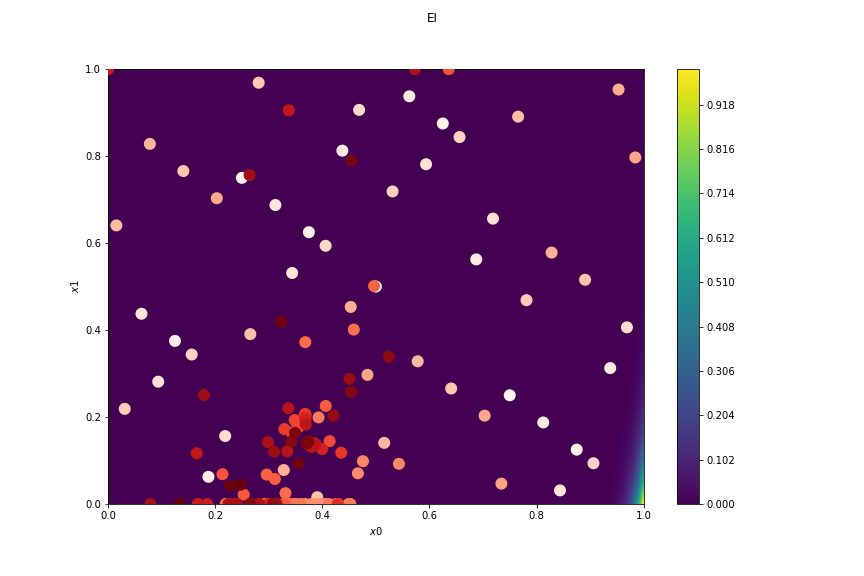

<IPython.core.display.Javascript object>


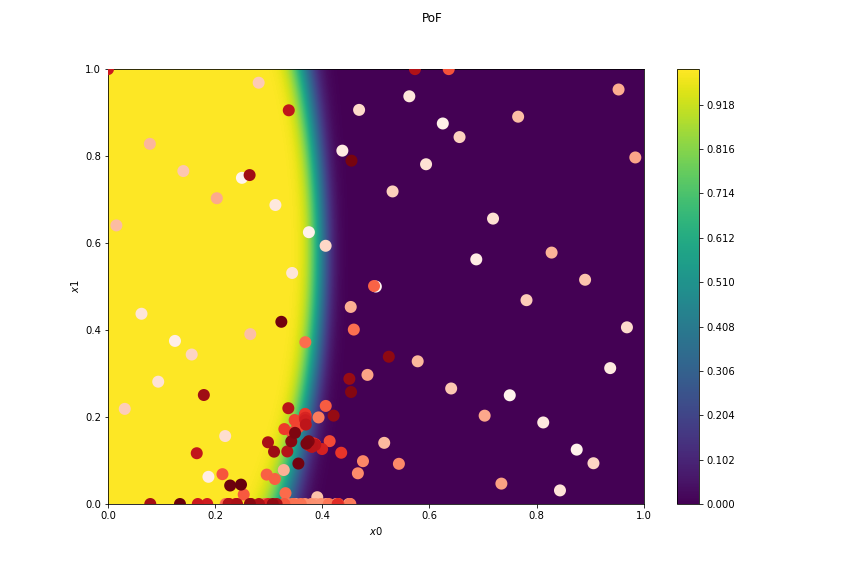

<IPython.core.display.Javascript object>


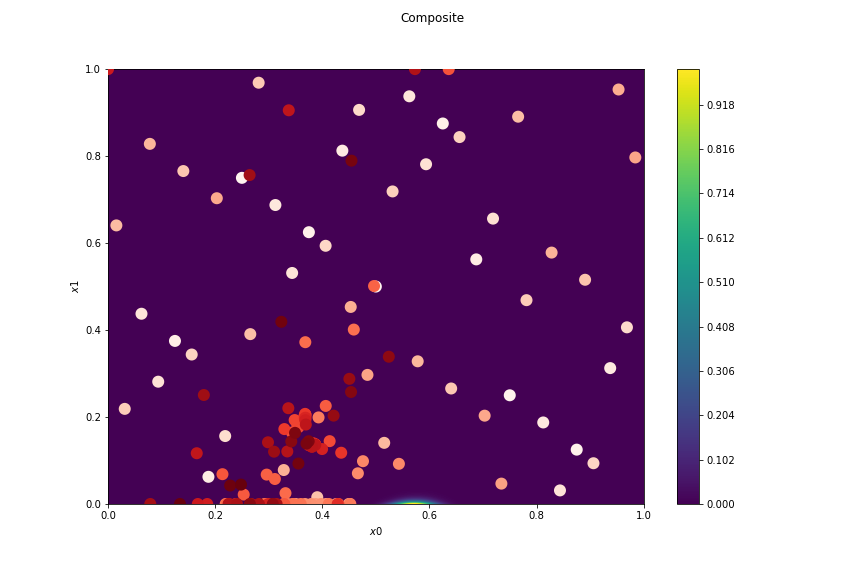

In [16]:
ei_plot = ei_acquisition.evaluate(x_plot_eval)
pof_plot = pof_acquisition.evaluate(x_plot_eval)
composite_plot = composite_acquisition.evaluate(x_plot_eval)
plot_acquisition(X[:,dim_to_plot[0]].squeeze(), X[:,dim_to_plot[1]].squeeze(), 
                 x_plot, ei_plot.squeeze(), pof_plot.squeeze(), composite_plot.squeeze())

In [ ]:
# # Only for 3D
# pof_plot_3d = pof_acquisition.evaluate(x_plot_3d)
# plot_pof_3d(X[:,0].squeeze(), X[:,1].squeeze(), X[:,2].squeeze(), x_plot_3d, pof_plot_3d.squeeze())

In [20]:
min_idx = 0
# Note that inf is not a good idea
min_val = float('inf')
min_val_list = []
for idx, val in enumerate(Y):
    # Could allow a little overspend by changing 0 to the value
    if val < min_val and Yc[idx] < 0:
        min_idx = idx
        min_val = val
    min_val_list.append(min_val)
print (min_idx)
print (Y[min_idx])
print (X[min_idx])
print (Yc[min_idx])

104
[1.01454103]
[4.00000000e+00 5.00000000e+00 2.74636433e-03 0.00000000e+00
 1.92950028e-01 3.86207042e-01 1.36365272e-01 1.00000000e+00]
[-0.7529077]


<IPython.core.display.Javascript object>


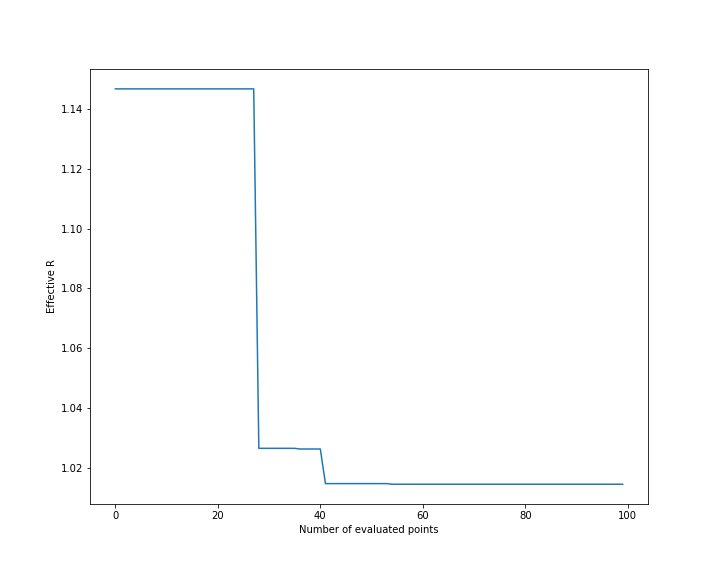

In [21]:
f, axes = plt.subplots(1, 1, figsize=(10, 8))
axes.plot(np.arange(0, Y[n_initial_points:].shape[0]), min_val_list[n_initial_points:])
axes.set_ylabel('Effective R')
axes.set_xlabel('Number of evaluated points');

In [22]:
print (composite_f(np.array([[4, 5, 0.13263884, 0, 0.29269327, 0.38945, 0.15488649, 1]])))


(array([[0.99257623]]), array([[-0.14132605]]))


In [23]:
# Compare to random sampling

min_idx = 0
# Note that inf is not a good idea
min_val = float('inf')
min_val_list = []
for idx, val in enumerate(Y_rand):
    # Could allow a little overspend by changing 0 to the value
    if val < min_val and Yc_rand[idx] < 0:
        min_idx = idx
        min_val = val
    min_val_list.append(min_val)
print (min_idx)
print (Y_rand[min_idx])
print (X_rand[min_idx])
print (Yc_rand[min_idx])

20
[1.146704]
[5.      3.      0.96875 0.78125 0.15625 0.21875 0.15625 0.96875]
[-13.02829983]


<IPython.core.display.Javascript object>


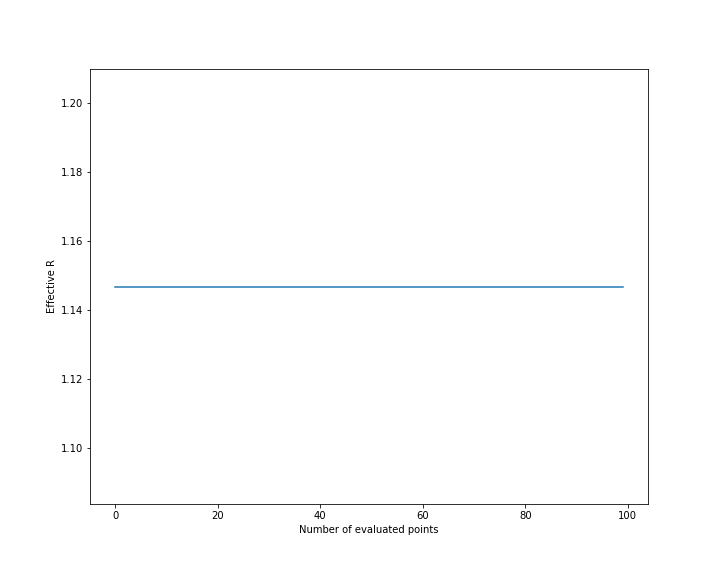

In [24]:
f, axes = plt.subplots(1, 1, figsize=(10, 8))
axes.plot(np.arange(0, Y_rand[n_initial_points:].shape[0]), min_val_list[n_initial_points:])
axes.set_ylabel('Effective R')
axes.set_xlabel('Number of evaluated points');